## Importing necessary libraries

In [2]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import itertools

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score

## Importing gender classfication data sets 

In [3]:
df1=pd.read_csv("gender_classification_v7.csv") 
df1.head()

,long_hair,forehead_width_cm,forehead_height_cm,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,gender
0,1,11.8,6.1,1,0,1,1,Male
1,0,14.0,5.4,0,0,1,0,Female
2,0,11.8,6.3,1,1,1,1,Male
3,0,14.4,6.1,0,1,1,1,Male
4,1,13.5,5.9,0,0,0,0,Female


## Exploring and cleaning the data set 

In [4]:
df1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   long_hair                  5001 non-null   int64  
 1   forehead_width_cm          5001 non-null   float64
 2   forehead_height_cm         5001 non-null   float64
 3   nose_wide                  5001 non-null   int64  
 4   nose_long                  5001 non-null   int64  
 5   lips_thin                  5001 non-null   int64  
 6   distance_nose_to_lip_long  5001 non-null   int64  
 7   gender                     5001 non-null   object 
dtypes: float64(2), int64(5), object(1)
memory usage: 312.7+ KB


No columns have missing values. Most columns are numerical (int64 or float64). Column 'gender' is of type 'object', which, as it comes from a csv file, typically means strings. It looks like it's a categorical feature, so we'll check how many categories there are and how many examples for each.

In [5]:
df1['gender'].value_counts()

Female    2501
Male      2500
Name: gender, dtype: int64

Now let's do some checks of the numerical columns.

In [6]:
df1.describe()

,long_hair,forehead_width_cm,forehead_height_cm,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long
count,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000
mean,0.869626,13.181484,5.946311,0.493901,0.507898,0.493101,0.498900
std,0.336748,1.107128,0.541268,0.500013,0.499988,0.500002,0.500049
min,0.000000,11.400000,5.100000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,12.200000,5.500000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,13.100000,5.900000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,14.000000,6.400000,1.000000,1.000000,1.000000,1.000000
max,1.000000,15.500000,7.100000,1.000000,1.000000,1.000000,1.000000


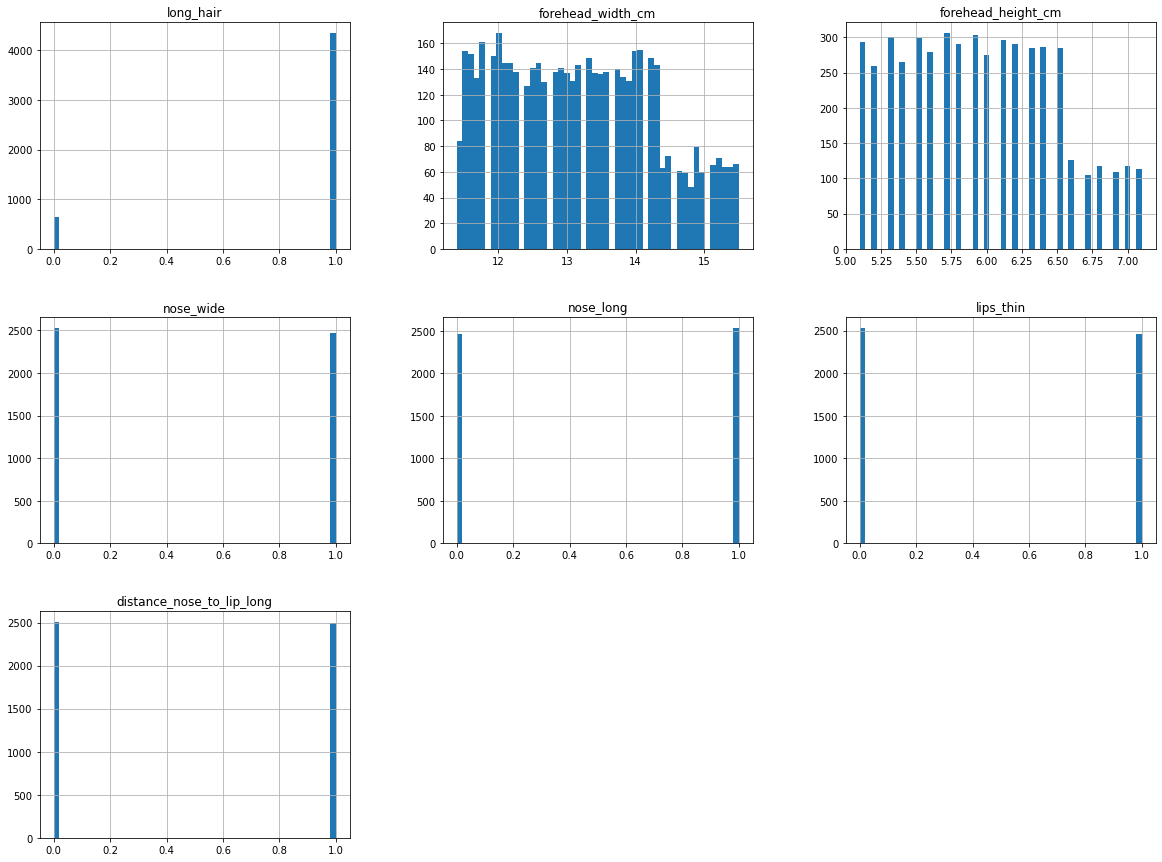

In [7]:
fig1 = df1.hist(bins=50, figsize=(20,15))

Here are some insights:

- 'long_hair', 'nose_wide', 'nose_long', 'lips_thin', and 'distance_nose_to_lip_long' appear as numerical features, but they are categorical.
- apart from 'long_hair' all the categorical values seem to be balanced and have equal no.of 0s and 1s.



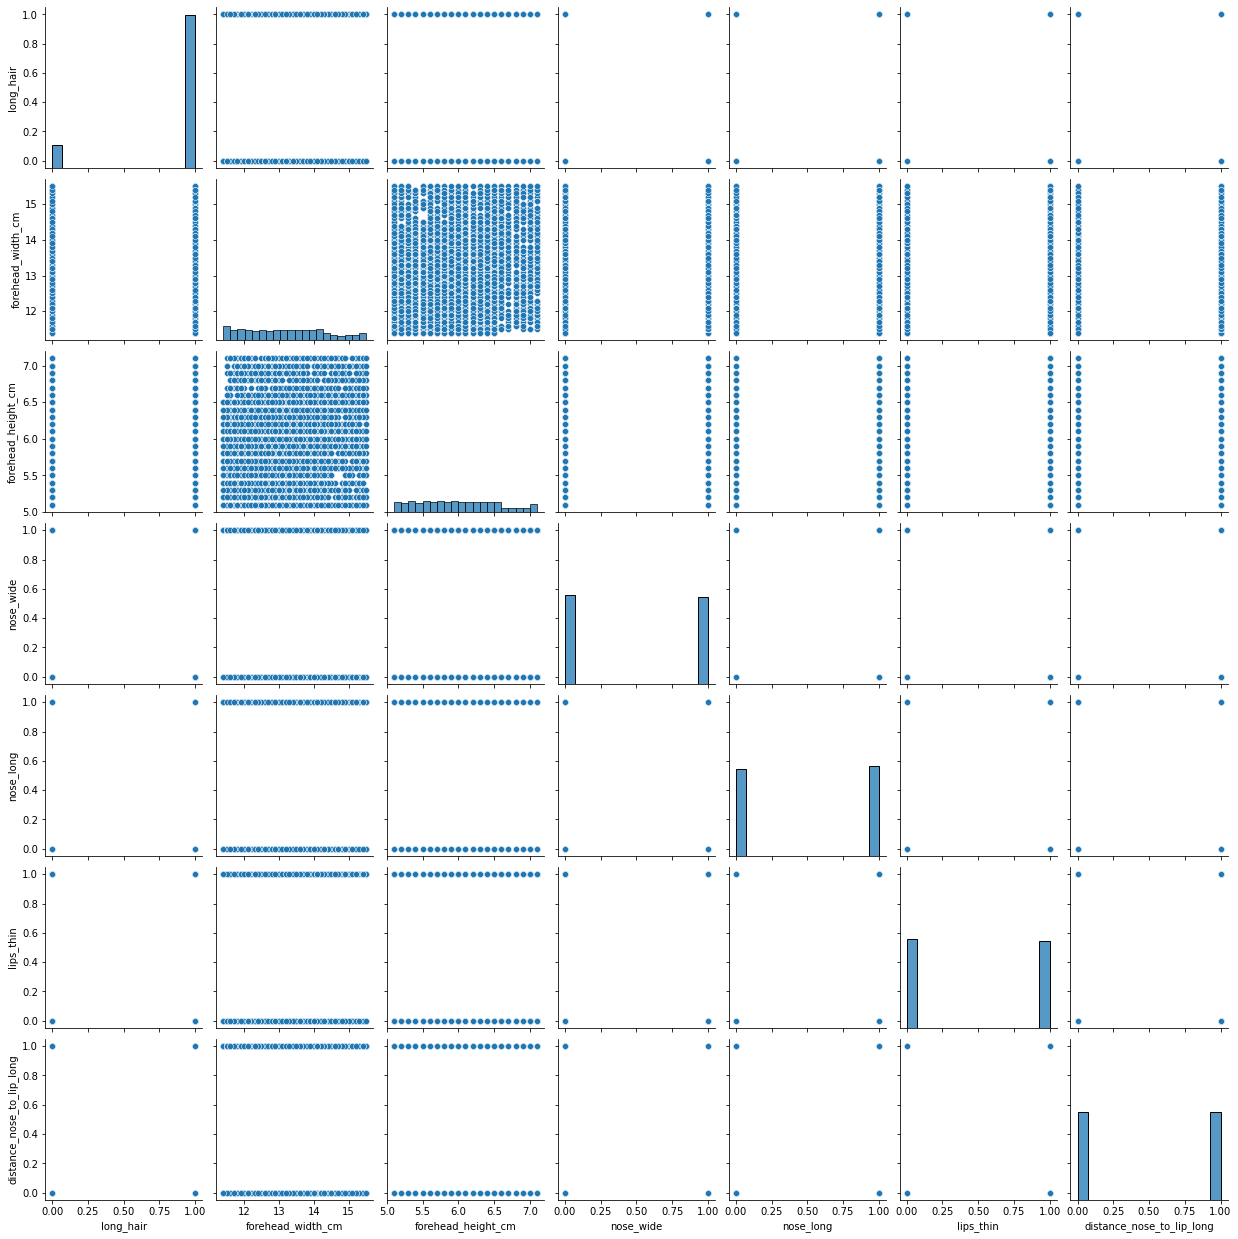

In [8]:
# Scatterplots
fig1_1= sns.pairplot(df1)

In [15]:
# Correlations 
df1.corr()

,long_hair,forehead_width_cm,forehead_height_cm,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long
long_hair,1.000000,-0.006530,-0.017233,0.001216,0.014432,0.011287,-0.025794
forehead_width_cm,-0.006530,1.000000,0.088596,0.251648,0.257368,0.258564,0.251328
forehead_height_cm,-0.017233,0.088596,1.000000,0.211655,0.194120,0.205441,0.215292
nose_wide,0.001216,0.251648,0.211655,1.000000,0.565192,0.557615,0.569303
nose_long,0.014432,0.257368,0.194120,0.565192,1.000000,0.561229,0.559794
lips_thin,0.011287,0.258564,0.205441,0.557615,0.561229,1.000000,0.565312
distance_nose_to_lip_long,-0.025794,0.251328,0.215292,0.569303,0.559794,0.565312,1.000000


## Low Imbalance for gender classification data set

In [16]:
df1_low_1=df1.loc[df1['gender'] == 'Male']
df1_low_2=df1.loc[df1['gender']=='Female']


In [17]:
df1_low_1 = df1_low_1.sample(frac =.35)
df1_low_2=df1_low_2.sample(frac=.65)

In [18]:
df1_low=pd.concat([df1_low_1,df1_low_2 ])

In [19]:
df1_low['gender'].value_counts()

Female    1626
Male       875
Name: gender, dtype: int64

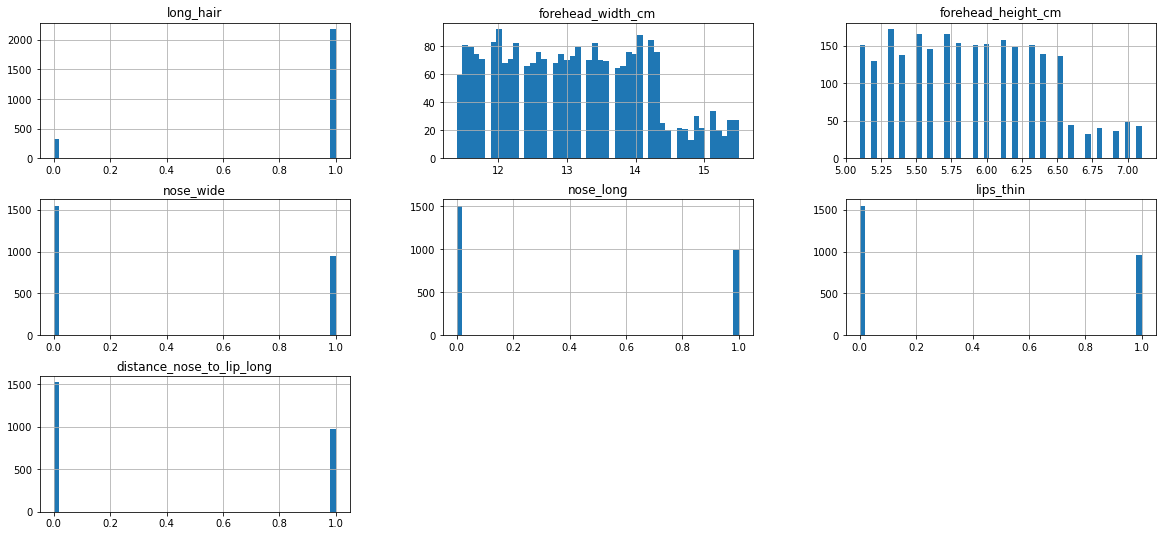

In [20]:
fig1_low = df1_low.hist(bins=50, figsize=(20,9))

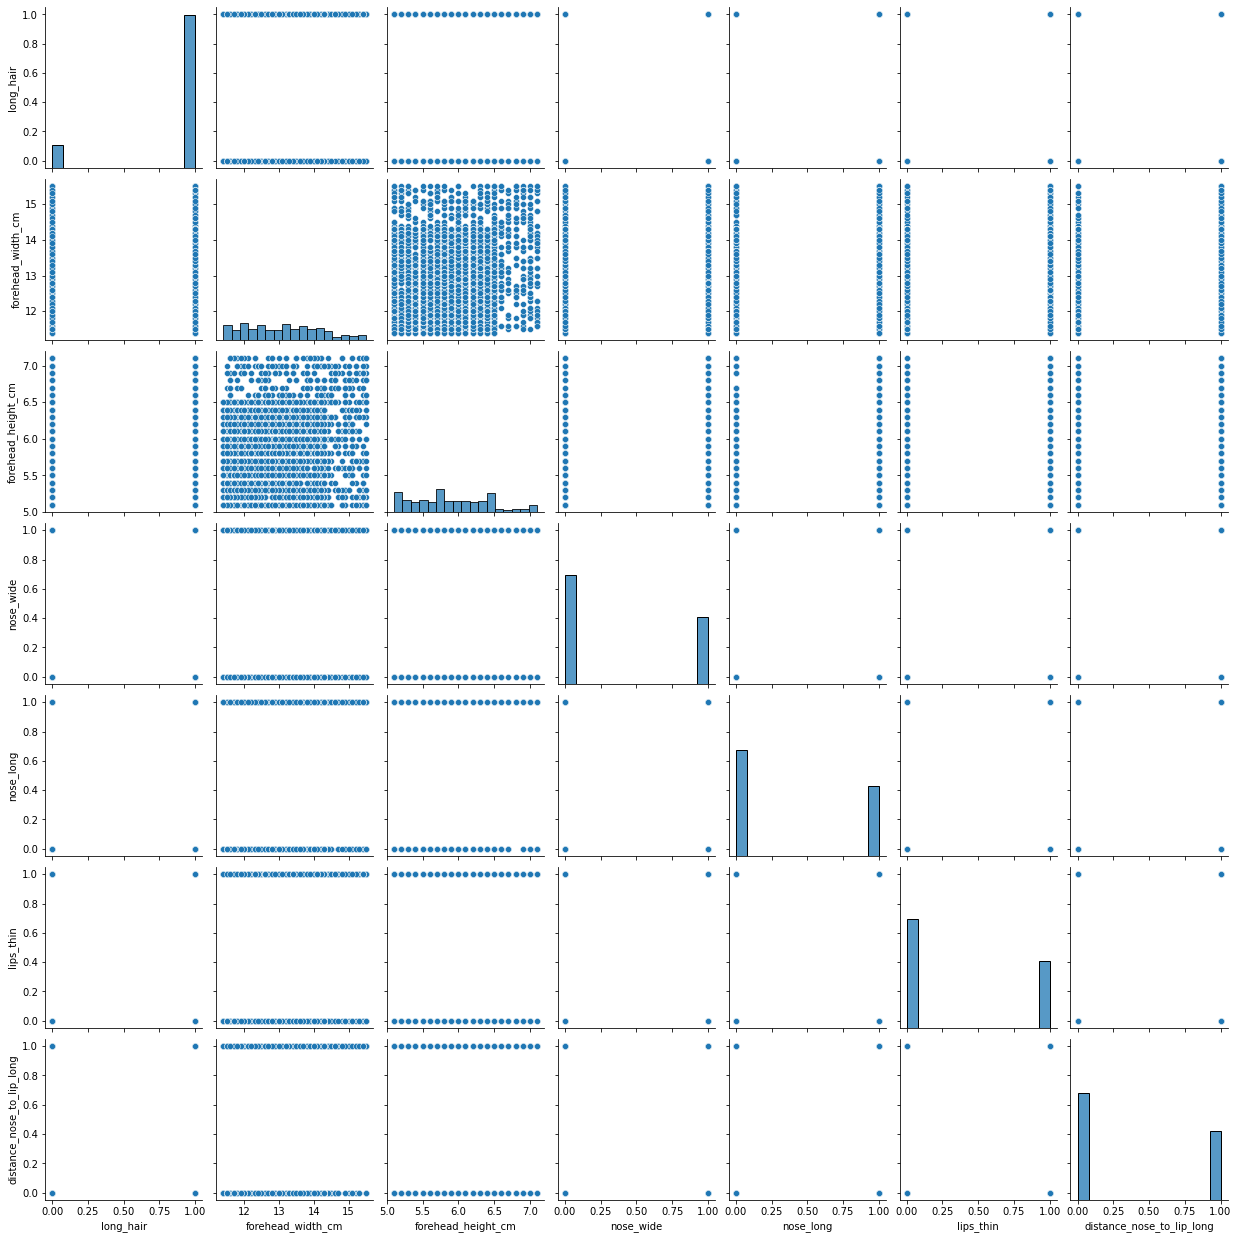

In [21]:
# Scatterplots
fig1_1_low= sns.pairplot(df1_low)

In [23]:
# Correlations  
df1_low.corr()

,long_hair,forehead_width_cm,forehead_height_cm,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long
long_hair,1.000000,-0.018133,-0.008604,0.013070,0.011295,0.018289,-0.047097
forehead_width_cm,-0.018133,1.000000,0.123711,0.262124,0.254562,0.254259,0.275607
forehead_height_cm,-0.008604,0.123711,1.000000,0.197380,0.214337,0.213926,0.233753
nose_wide,0.013070,0.262124,0.197380,1.000000,0.543650,0.537934,0.561484
nose_long,0.011295,0.254562,0.214337,0.543650,1.000000,0.541189,0.533694
lips_thin,0.018289,0.254259,0.213926,0.537934,0.541189,1.000000,0.540465
distance_nose_to_lip_long,-0.047097,0.275607,0.233753,0.561484,0.533694,0.540465,1.000000


## Medium imbalance on gender classification data set

In [25]:
df1_medium_1=df1.loc[df1['gender'] == 'Male']
df1_medium_2=df1.loc[df1['gender']=='Female']

In [26]:
df1_medium_1 = df1_medium_1.sample(frac =.25)
df1_medium_2=df1_medium_2.sample(frac=.75)

In [27]:
df1_medium=pd.concat([df1_medium_1,df1_medium_2 ])

In [28]:
df1_medium['gender'].value_counts()

Female    1876
Male       625
Name: gender, dtype: int64

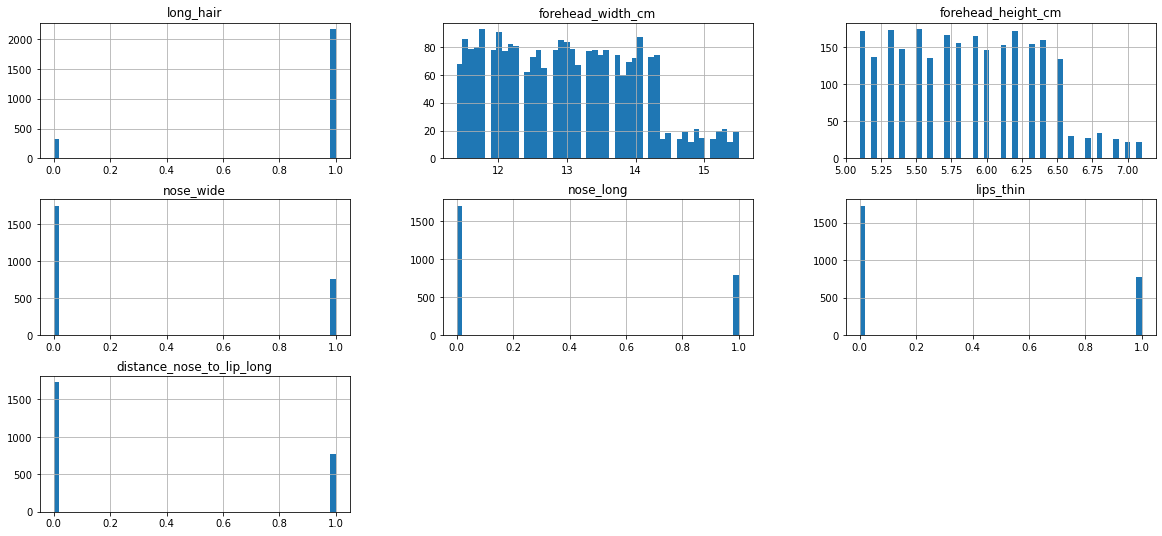

In [29]:
fig1_medium = df1_medium.hist(bins=50, figsize=(20,9))

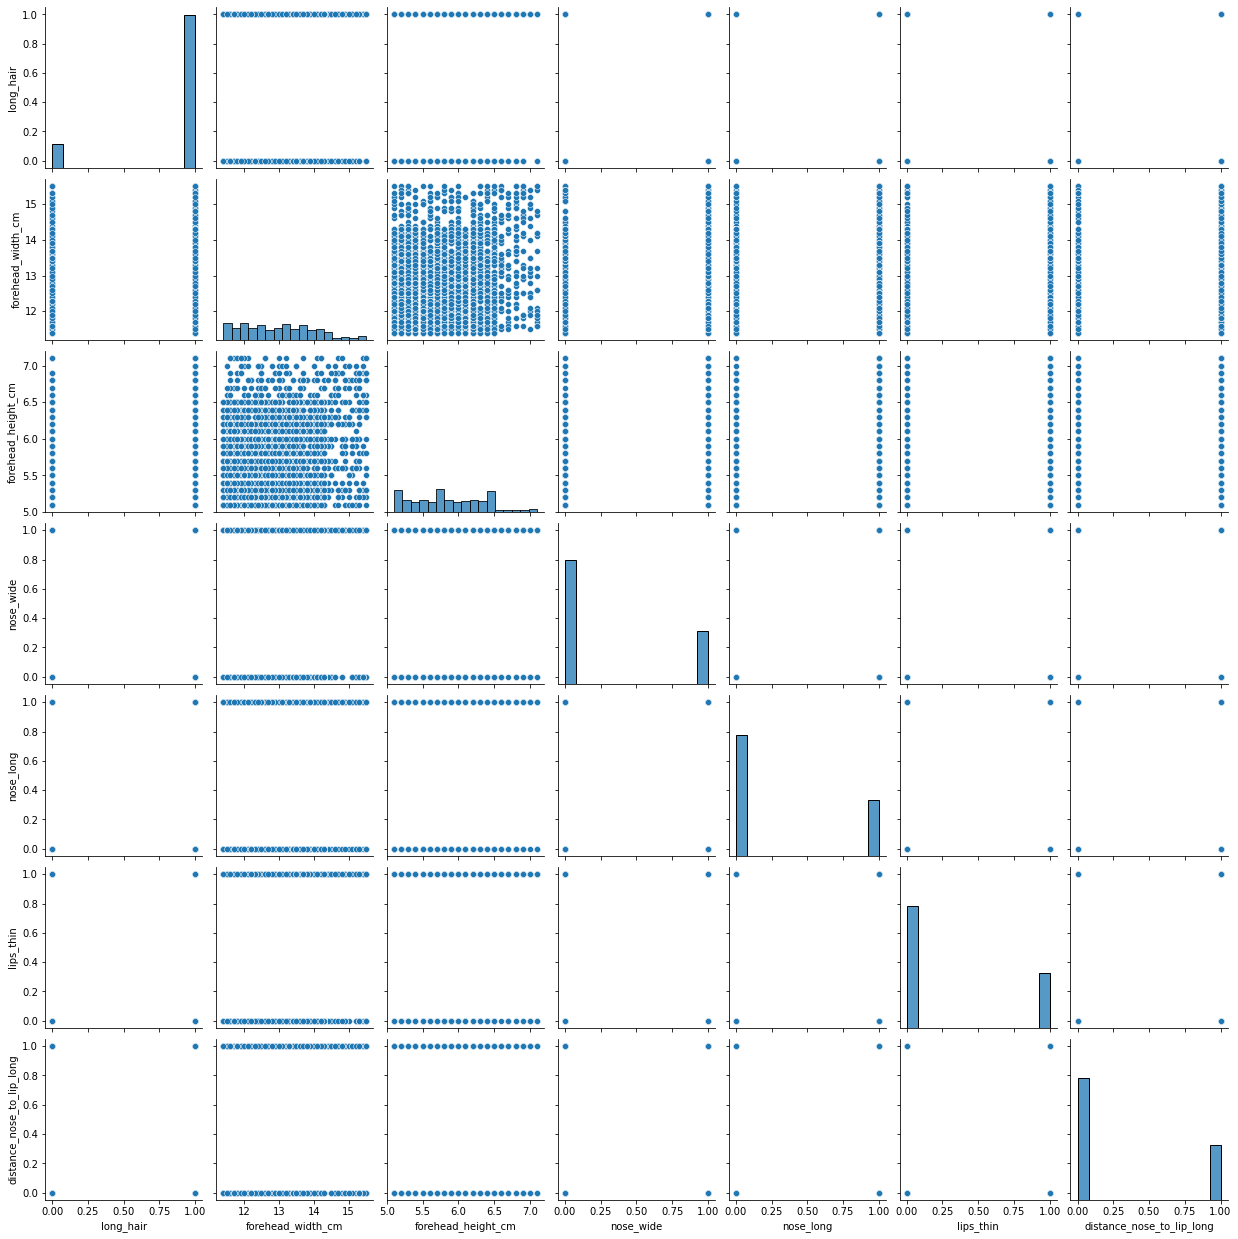

In [30]:
# Scatterplots
fig1_1_medium= sns.pairplot(df1_medium)

In [31]:
# Correlations
correlations_1 = df1.corr()  
df1_medium.corr()

,long_hair,forehead_width_cm,forehead_height_cm,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long
long_hair,1.000000,-0.012604,-0.003000,0.023424,0.032482,0.033238,-0.023119
forehead_width_cm,-0.012604,1.000000,0.102736,0.257015,0.245337,0.247768,0.233403
forehead_height_cm,-0.003000,0.102736,1.000000,0.177534,0.171735,0.193752,0.208244
nose_wide,0.023424,0.257015,0.177534,1.000000,0.475556,0.489049,0.519981
nose_long,0.032482,0.245337,0.171735,0.475556,1.000000,0.488455,0.491078
lips_thin,0.033238,0.247768,0.193752,0.489049,0.488455,1.000000,0.518039
distance_nose_to_lip_long,-0.023119,0.233403,0.208244,0.519981,0.491078,0.518039,1.000000


## High imbalance on gender classification data set

In [32]:
df1_high_1=df1.loc[df1['gender'] == 'Male']
df1_high_2=df1.loc[df1['gender']=='Female']

In [33]:
df1_high_1 = df1_high_1.sample(frac =.10)
df1_high_2=df1_high_2.sample(frac=.90)

In [34]:
df1_high=pd.concat([df1_high_1,df1_high_2 ])

In [35]:
df1_high['gender'].value_counts()

Female    2251
Male       250
Name: gender, dtype: int64

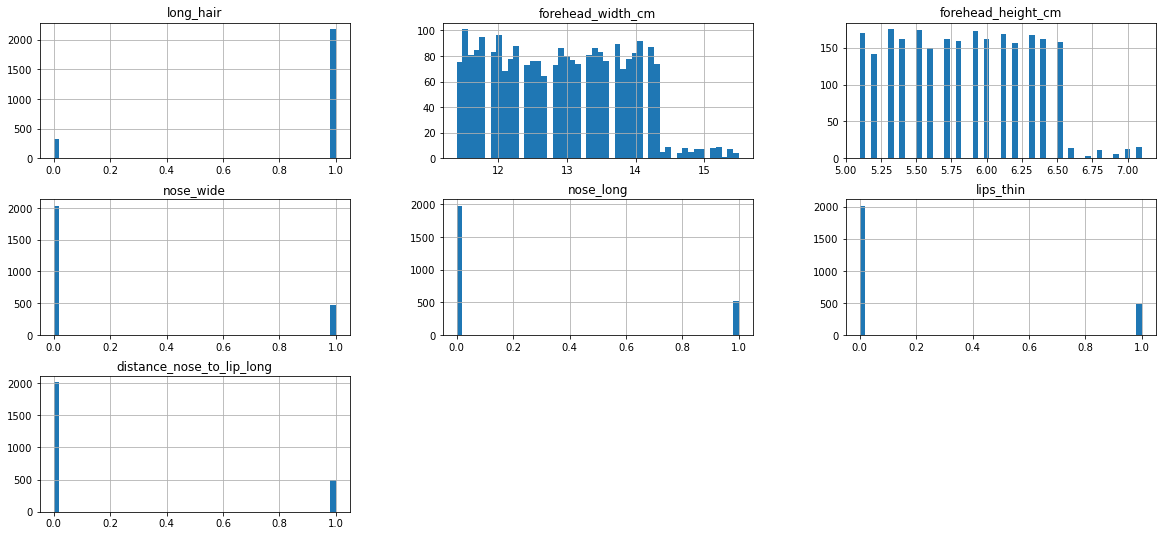

In [36]:
fig1_high = df1_high.hist(bins=50, figsize=(20,9))

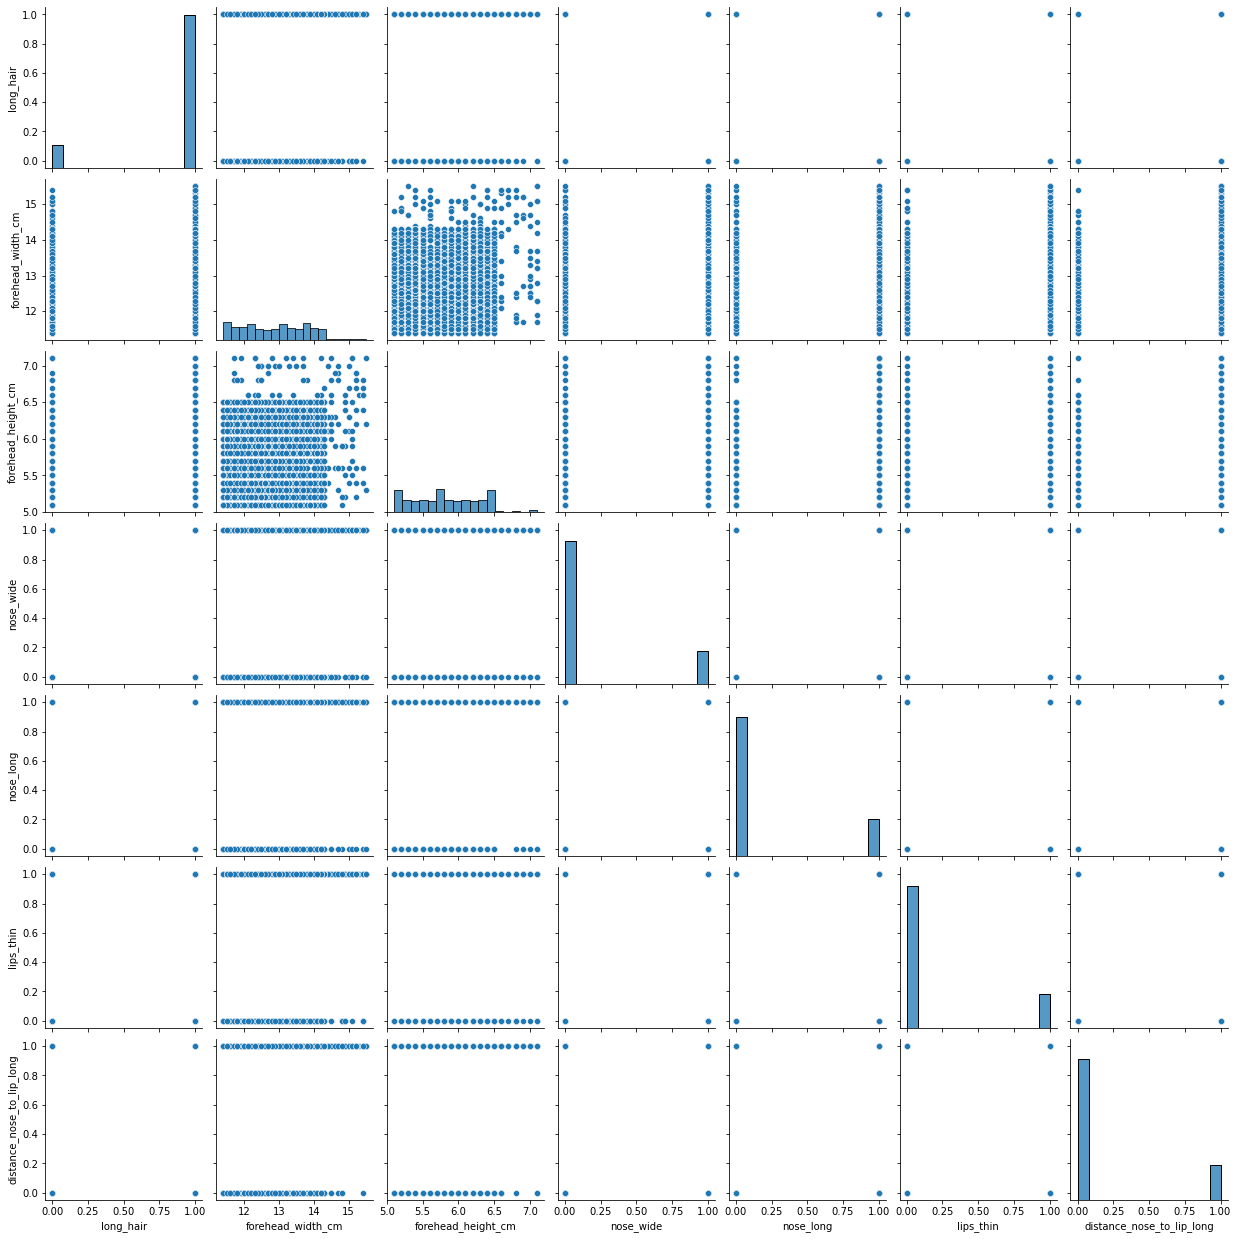

In [37]:
# Scatterplots
fig1_1_high= sns.pairplot(df1_high)

In [38]:
# Correlations  
df1_high.corr()

,long_hair,forehead_width_cm,forehead_height_cm,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long
long_hair,1.000000,-0.010749,-0.012605,0.015150,0.003686,0.016621,-0.050254
forehead_width_cm,-0.010749,1.000000,0.068090,0.129042,0.130566,0.133810,0.133736
forehead_height_cm,-0.012605,0.068090,1.000000,0.057707,0.109371,0.132213,0.110649
nose_wide,0.015150,0.129042,0.057707,1.000000,0.275206,0.292963,0.304195
nose_long,0.003686,0.130566,0.109371,0.275206,1.000000,0.319981,0.312929
lips_thin,0.016621,0.133810,0.132213,0.292963,0.319981,1.000000,0.342653
distance_nose_to_lip_long,-0.050254,0.133736,0.110649,0.304195,0.312929,0.342653,1.000000


## Importing Iris data sets

In [39]:
df2=pd.read_csv("IRIS.csv")
df2.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [40]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


No columns have missing values. All columns are numerical (float64). Column 'species' is of type 'object', which, as it comes from a csv file, typically means strings. It looks like it's a categorical feature, so we'll check how many categories there are and how many examples for each.

In [41]:
df2['species'].value_counts()

Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: species, dtype: int64

Now let's do some checks of the numerical columns.

In [42]:
df2.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


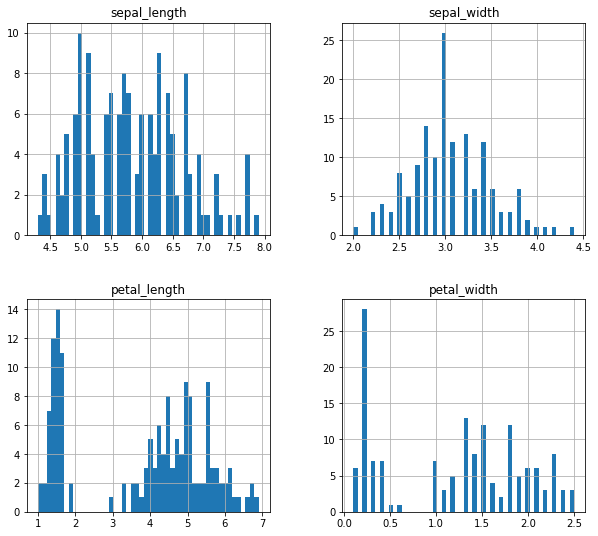

In [43]:
fig2 = df2.hist(bins=50, figsize=(10,9))

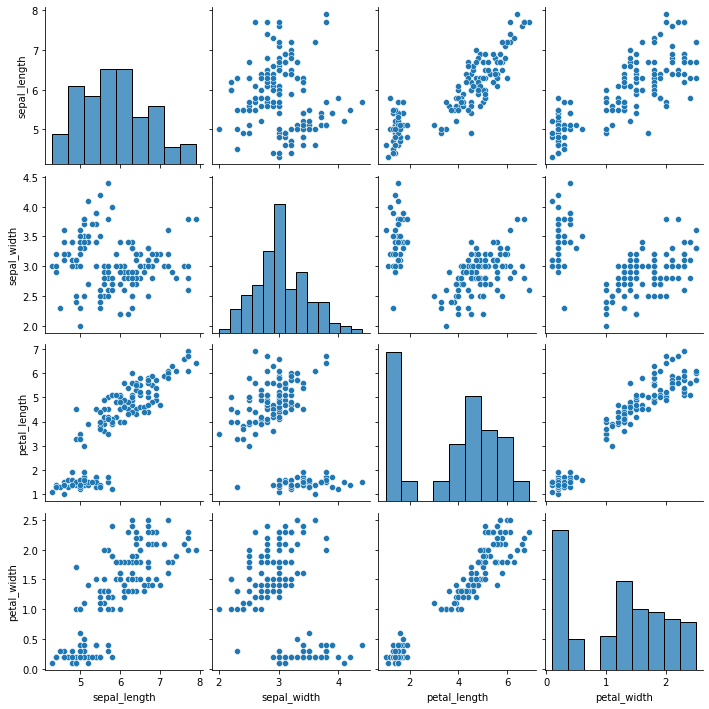

In [44]:
# Scatterplots
fig2_1= sns.pairplot(df2)

In [45]:
#Correlations
df2.corr()

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,1.000000,-0.109369,0.871754,0.817954
sepal_width,-0.109369,1.000000,-0.420516,-0.356544
petal_length,0.871754,-0.420516,1.000000,0.962757
petal_width,0.817954,-0.356544,0.962757,1.000000


## Low imbalance on iris data set

In [46]:
df2_low_1=df2.loc[df2['species'] == 'Iris-setosa']
df2_low_2=df2.loc[df2['species']=='Iris-versicolor']
df2_low_3=df2.loc[df2['species']=='Iris-virginica']

In [47]:
df2_low_1 = df2_low_1.sample(frac =.65)
df2_low_2=df2_low_2.sample(frac=.10)
df2_low_3=df2_low_3.sample(frac=.25)

In [48]:
df2_low=pd.concat([df2_low_1,df2_low_2,df2_low_3])
df2_low['species'].value_counts()

Iris-setosa        32
Iris-virginica     12
Iris-versicolor     5
Name: species, dtype: int64

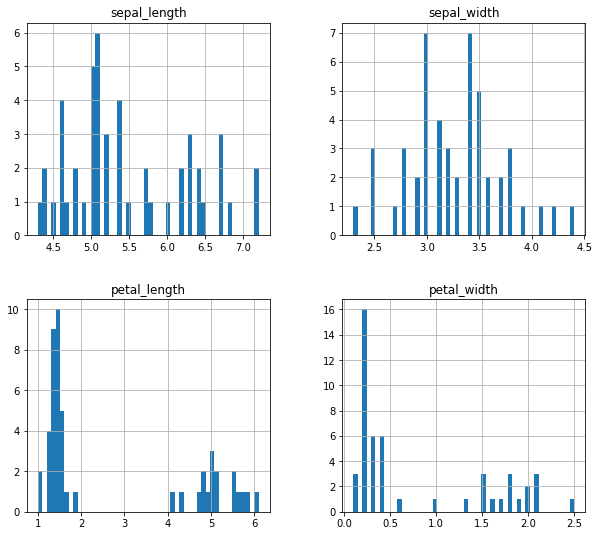

In [49]:
fig2_low = df2_low.hist(bins=50, figsize=(10,9))

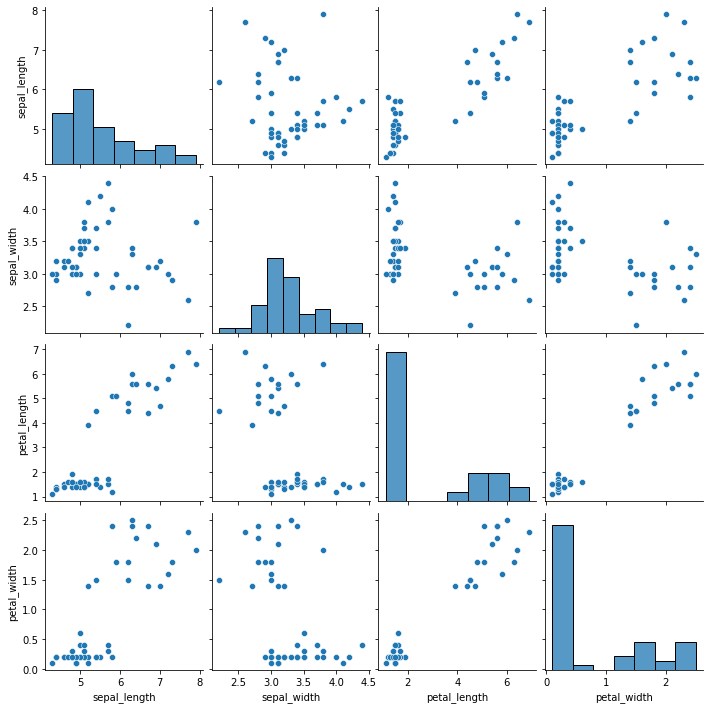

In [118]:
# Scatterplots
fig2_1_low= sns.pairplot(df2_low)

In [50]:
#Correlations
df2_low.corr()

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,1.000000,-0.211357,0.916837,0.891626
sepal_width,-0.211357,1.000000,-0.499994,-0.467738
petal_length,0.916837,-0.499994,1.000000,0.977658
petal_width,0.891626,-0.467738,0.977658,1.000000


## Medium imbalance on iris data set

In [51]:
df2_medium_1=df2.loc[df2['species'] == 'Iris-setosa']
df2_medium_2=df2.loc[df2['species']=='Iris-versicolor']
df2_medium_3=df2.loc[df2['species']=='Iris-virginica']

In [52]:
df2_medium_1 = df2_medium_1.sample(frac =.75)
df2_medium_2=df2_medium_2.sample(frac=.05)
df2_medium_3=df2_medium_3.sample(frac=.15)

In [53]:
df2_medium=pd.concat([df2_medium_1,df2_medium_2,df2_medium_3])
df2_medium['species'].value_counts()

Iris-setosa        38
Iris-virginica      8
Iris-versicolor     2
Name: species, dtype: int64

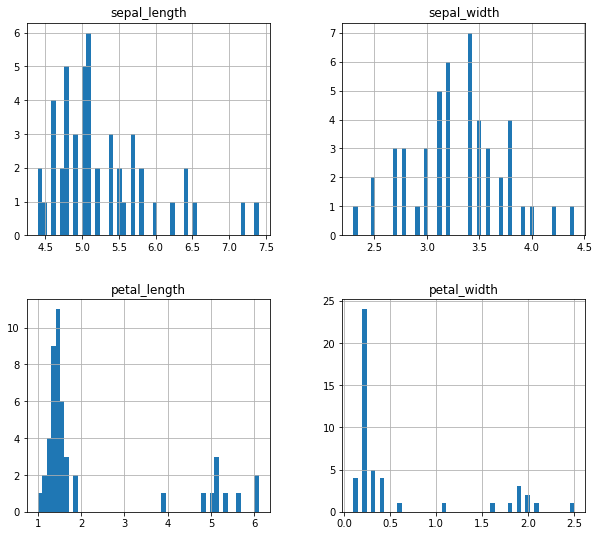

In [54]:
fig2_medium = df2_medium.hist(bins=50, figsize=(10,9))

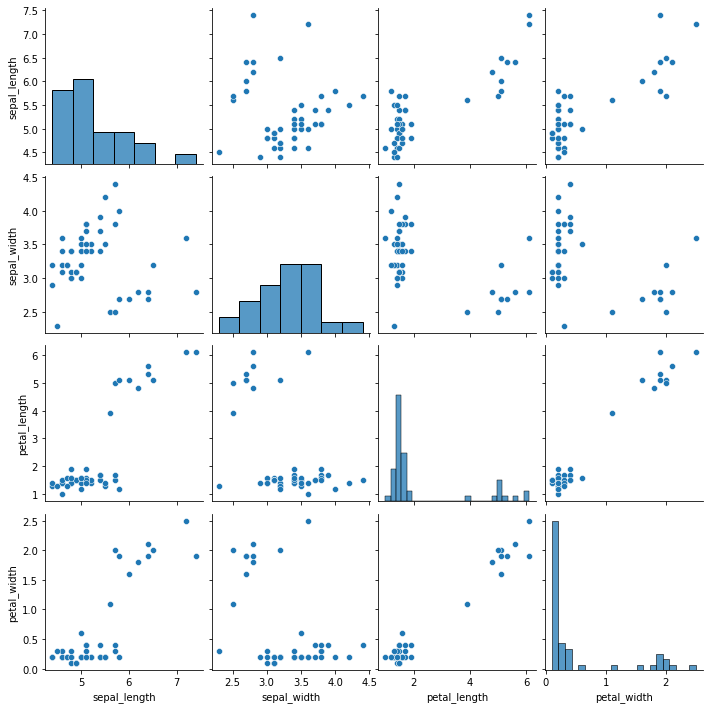

In [55]:
# Scatterplots
fig2_1_medium= sns.pairplot(df2_medium)

In [56]:
#Correlations
df2_medium.corr()

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,1.000000,-0.063827,0.845226,0.832259
sepal_width,-0.063827,1.000000,-0.476738,-0.429970
petal_length,0.845226,-0.476738,1.000000,0.982186
petal_width,0.832259,-0.429970,0.982186,1.000000


## High imbalance on iris data set

In [57]:
df2_high_1=df2.loc[df2['species'] == 'Iris-setosa']
df2_high_2=df2.loc[df2['species']=='Iris-versicolor']
df2_high_3=df2.loc[df2['species']=='Iris-virginica']

In [58]:
df2_high_1 = df2_high_1.sample(frac =.90)
df2_high_2=df2_high_2.sample(frac=.05)
df2_high_3=df2_high_3.sample(frac=.05)

In [59]:
df2_high=pd.concat([df2_high_1,df2_high_2,df2_high_3])
df2_high['species'].value_counts()

Iris-setosa        45
Iris-versicolor     2
Iris-virginica      2
Name: species, dtype: int64

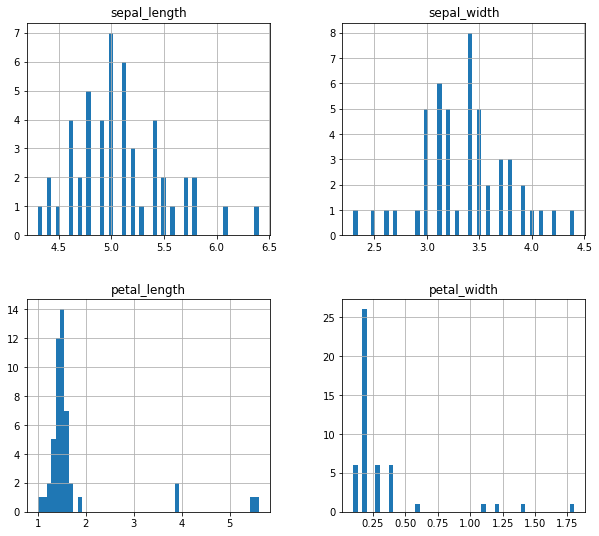

In [60]:
fig2_high = df2_high.hist(bins=50, figsize=(10,9))

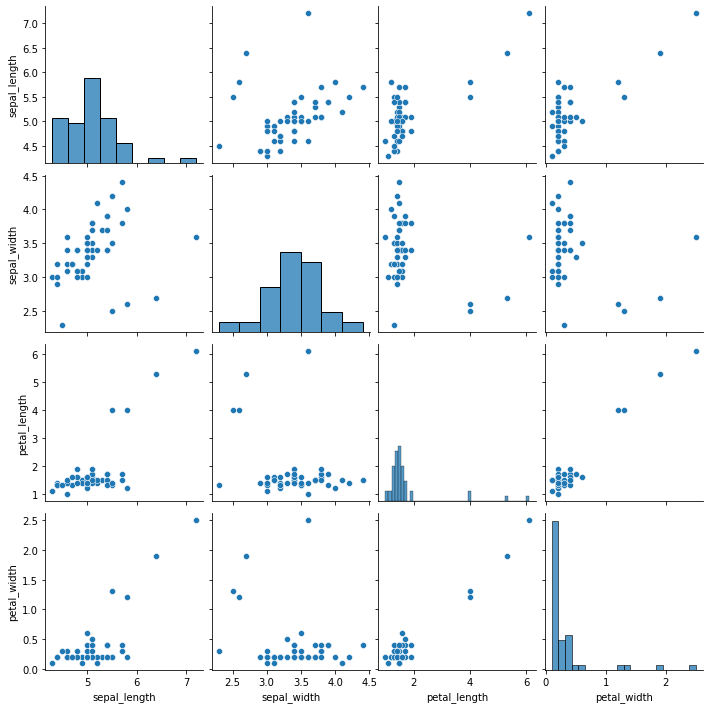

In [120]:
# Scatterplots
fig2_1_high= sns.pairplot(df2_high)

In [61]:
#Correlations
df2_high.corr()

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,1.000000,0.265612,0.650014,0.673345
sepal_width,0.265612,1.000000,-0.390083,-0.313402
petal_length,0.650014,-0.390083,1.000000,0.944291
petal_width,0.673345,-0.313402,0.944291,1.000000


## Importing heart attack dataset

In [62]:
df3=pd.read_csv("heart.csv")
df3.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [63]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


No columns have missing values. ALl the columns are numerical (int64 or float64).

In [64]:
df3['output'].value_counts()

1    165
0    138
Name: output, dtype: int64

In [65]:
df3.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


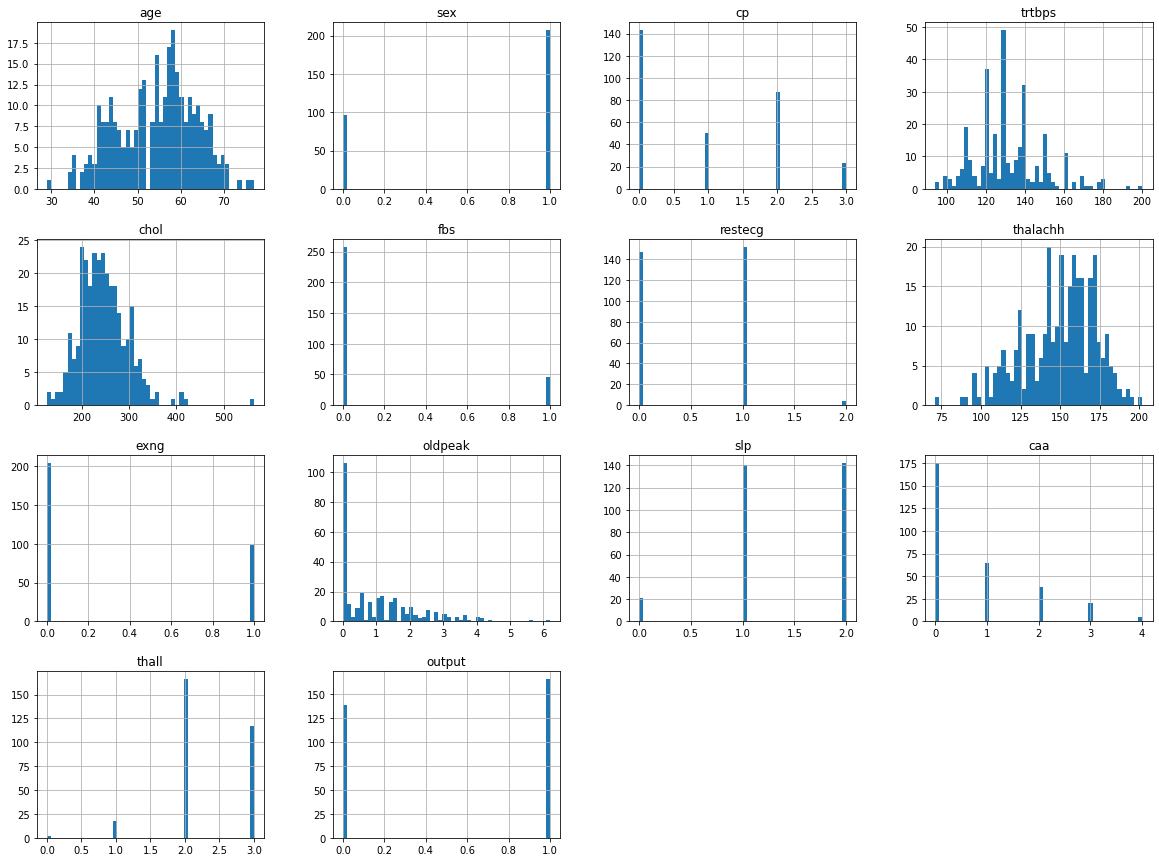

In [66]:
fig3 = df3.hist(bins=50, figsize=(20,15))

Here is an insight:
'sex', 'fbs', 'restecg', 'exng', and 'output' appear as numerical features, but they are categorical.



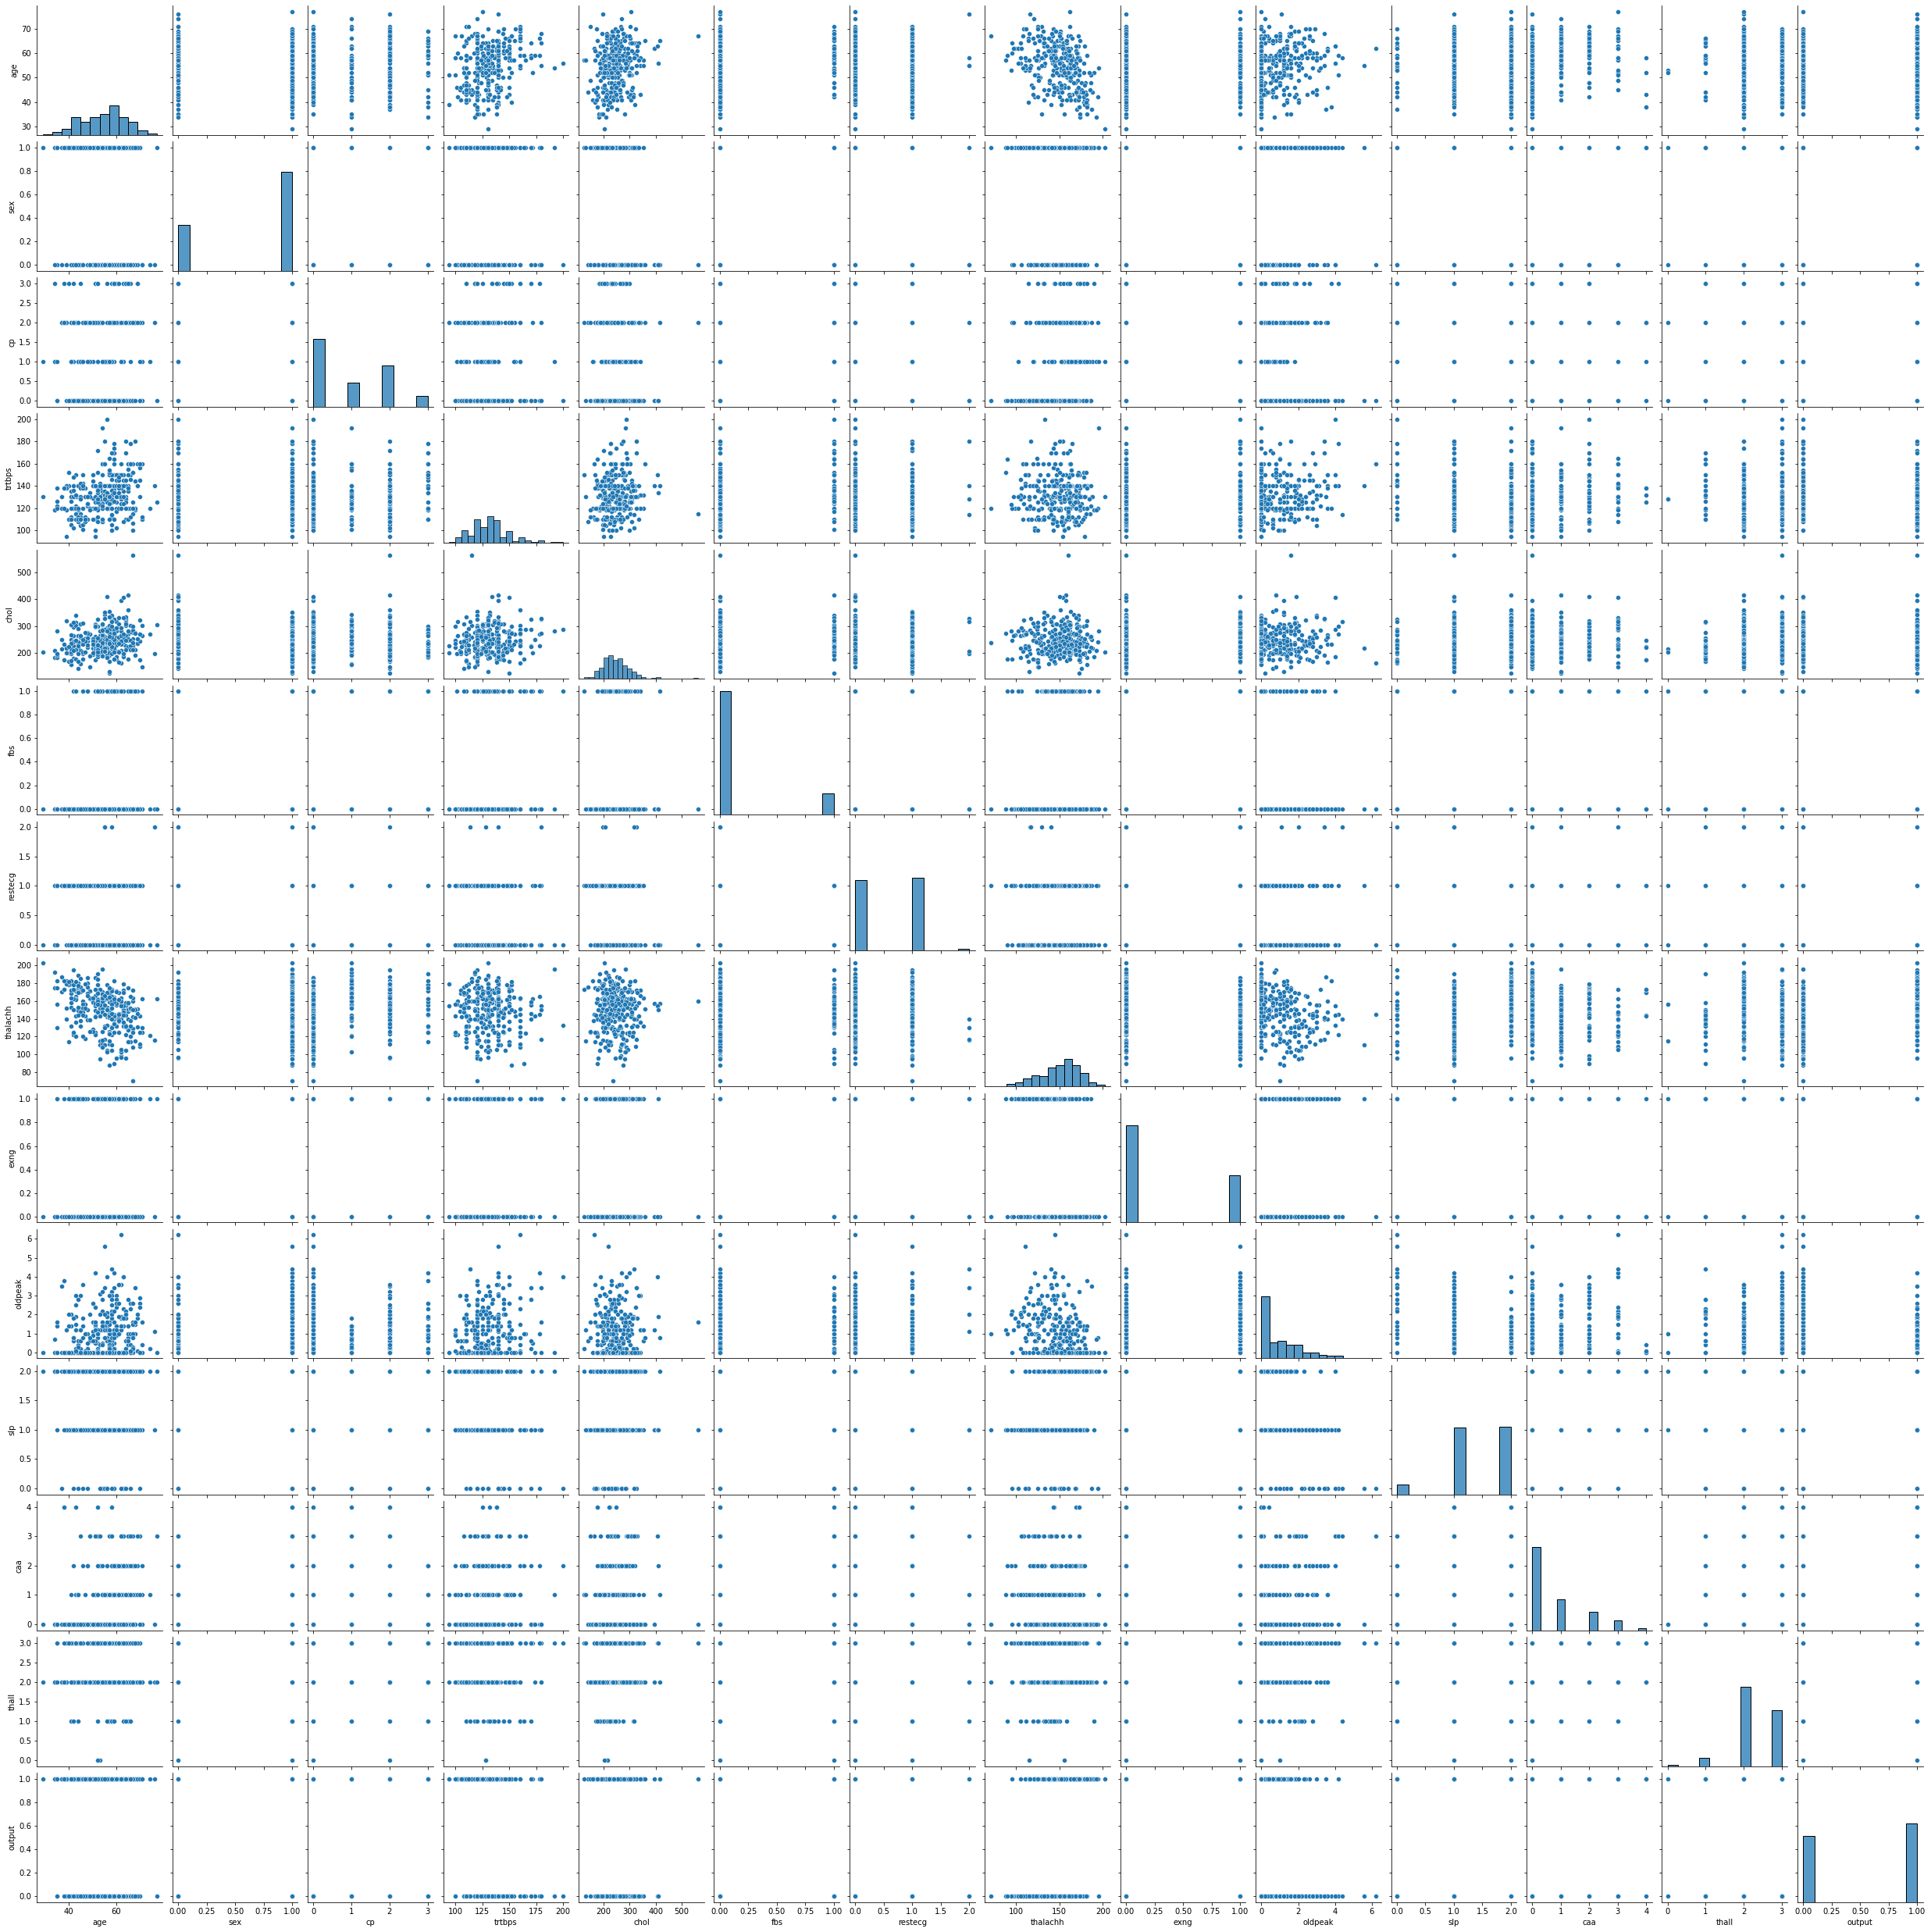

In [89]:
# Scatterplots
fig3_1= sns.pairplot(df3)

## Low imbalance on heart attack data set

In [68]:
df3_low_1=df3.loc[df3['output'] == 0]
df3_low_2=df3.loc[df3['output']==1]

In [69]:
df3_low_1 = df3_low_1.sample(frac =.65)
df3_low_2=df3_low_2.sample(frac=.35)

In [70]:
df3_low=pd.concat([df3_low_1,df3_low_2 ])
df3_low['output'].value_counts()

0    90
1    58
Name: output, dtype: int64

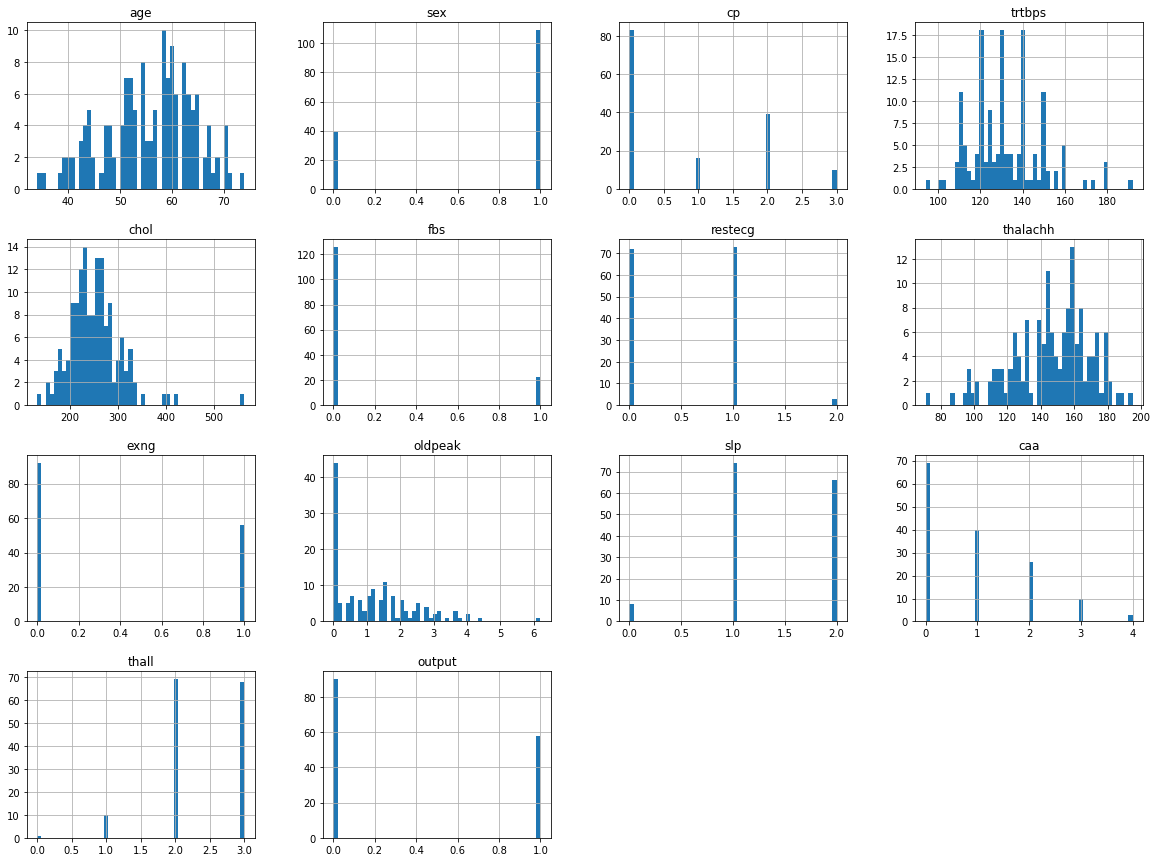

In [71]:
fig3_low = df3_low.hist(bins=50, figsize=(20,15))

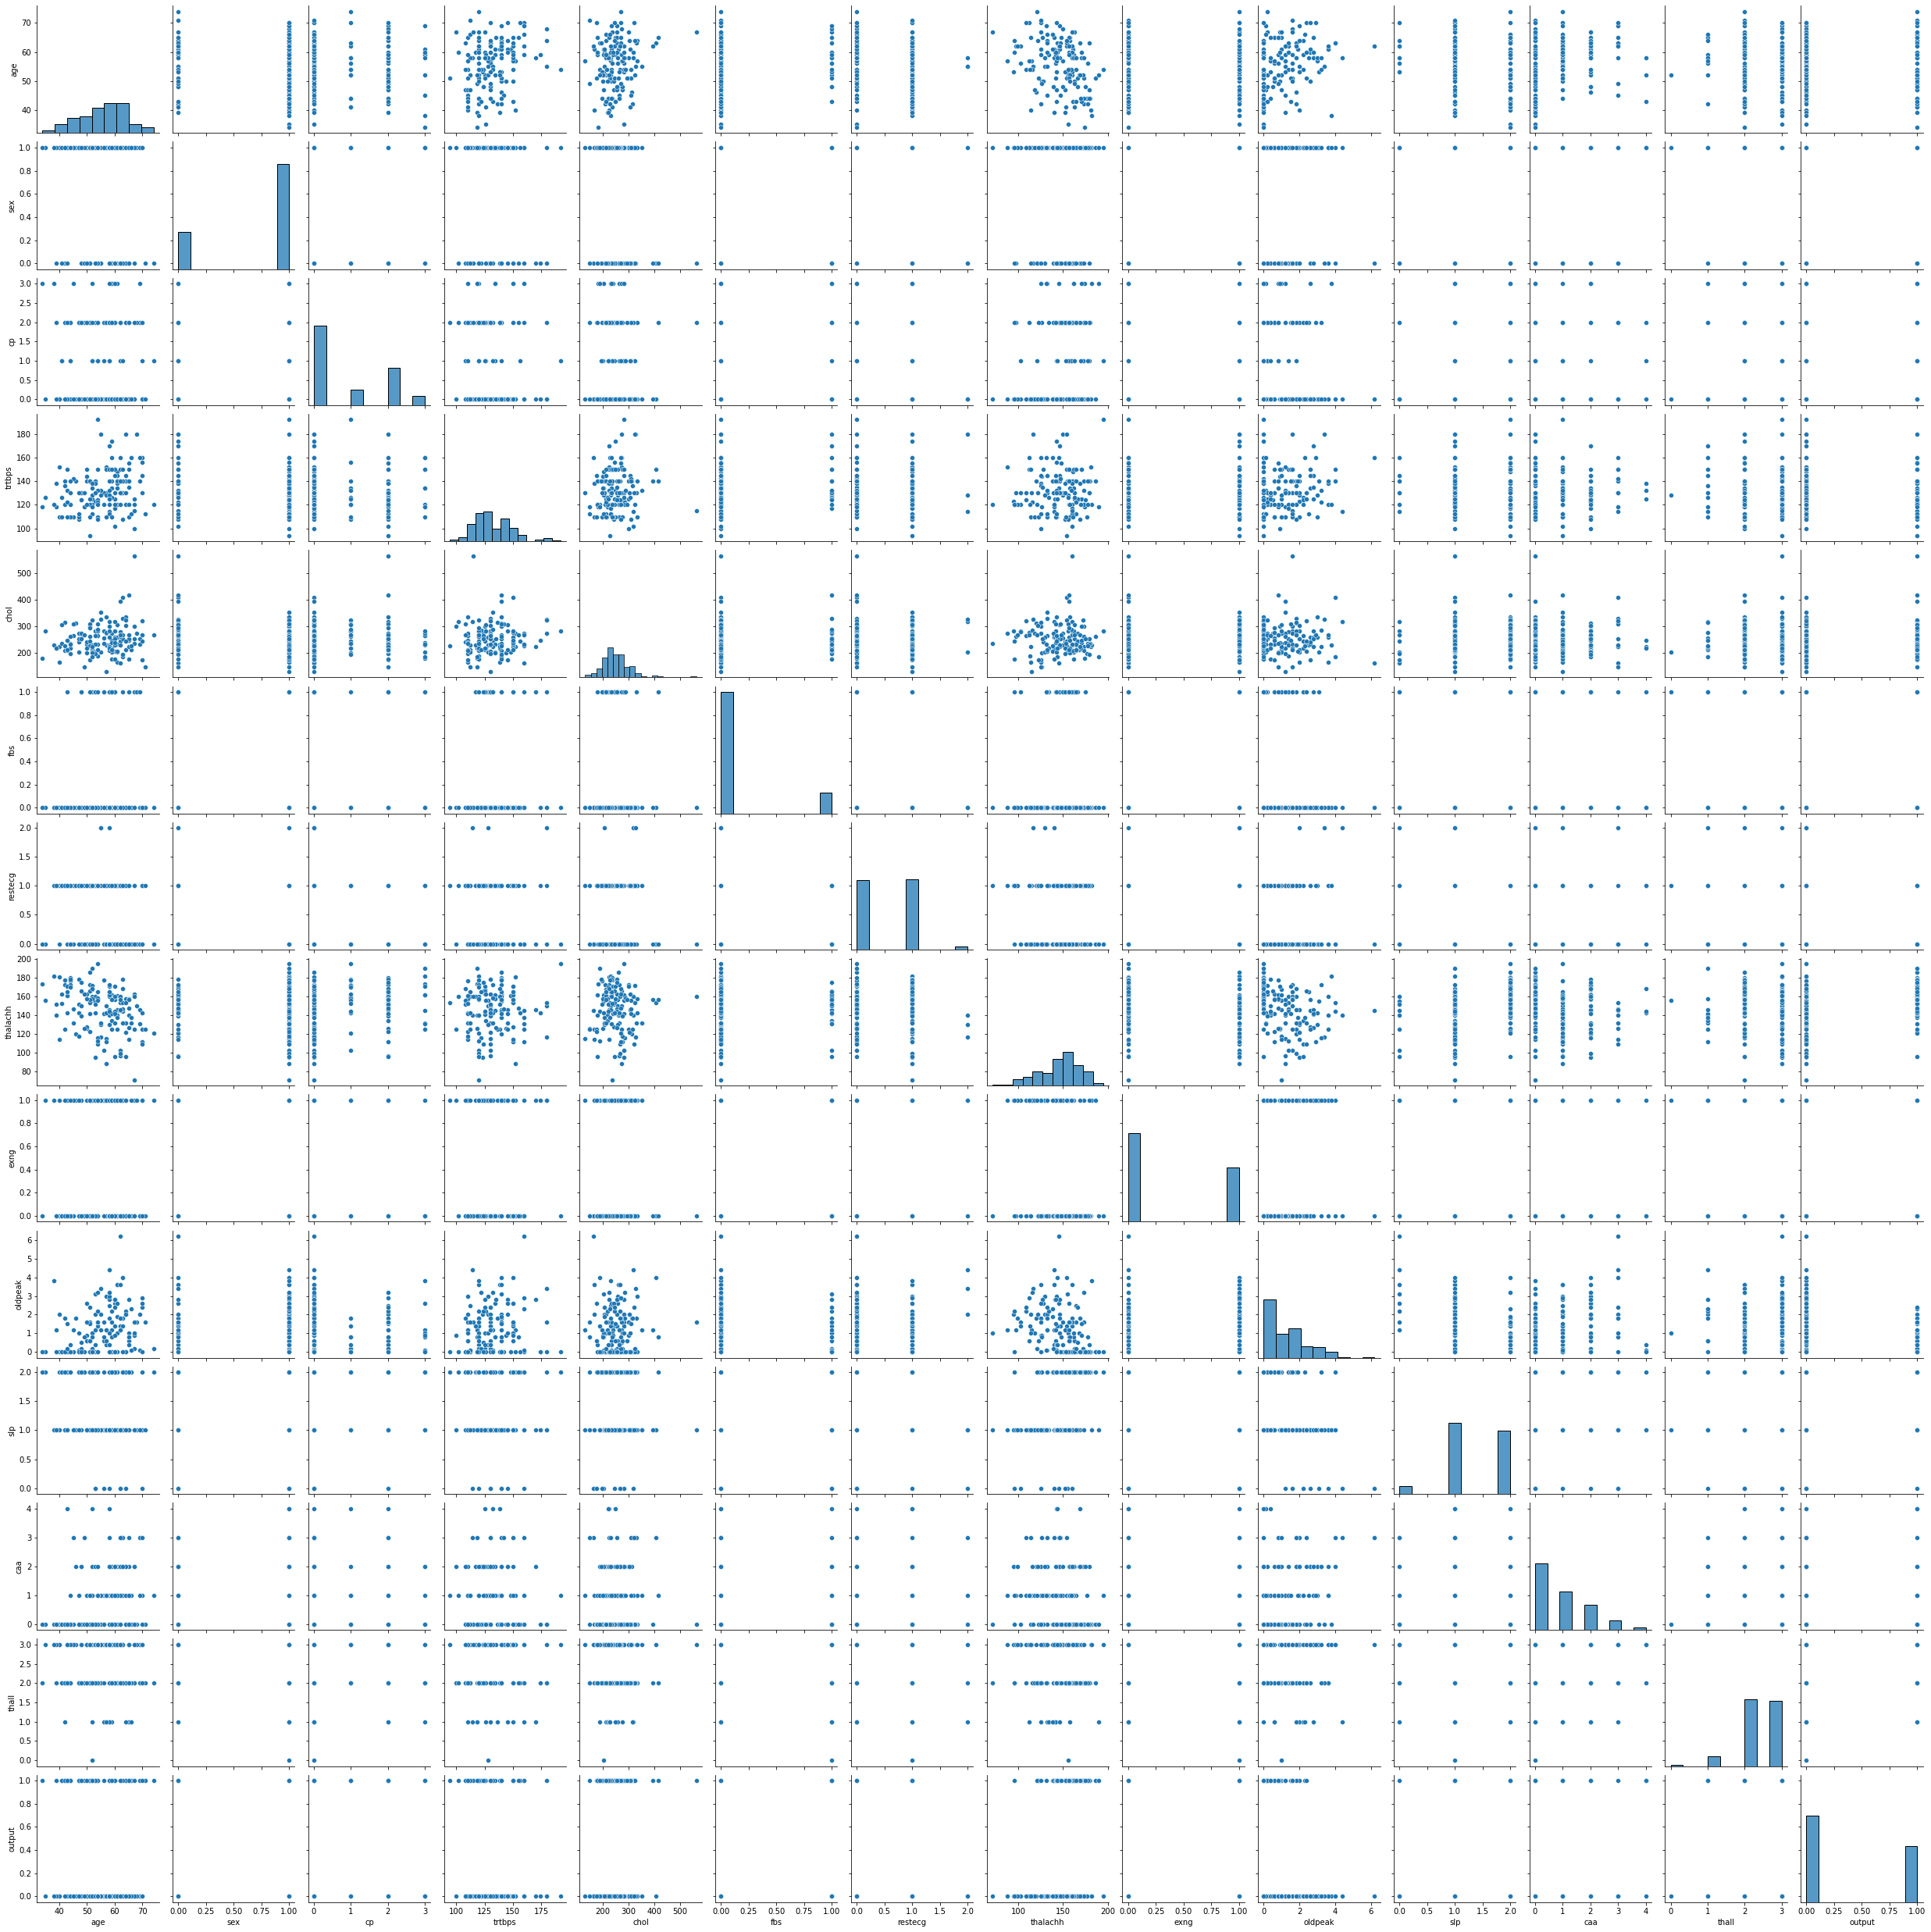

In [72]:
# Scatterplots
fig3_1_low= sns.pairplot(df3_low)

## Medium imbalance on heart attack data set

In [73]:
df3_medium_1=df3.loc[df3['output'] == 0]
df3_medium=df3.loc[df3['output']==1]

In [74]:
df3_medium_1 = df3_low_1.sample(frac =.75)
df3_medium_2=df3_low_2.sample(frac=.25)

In [75]:
df3_medium=pd.concat([df3_medium_1,df3_medium_2 ])
df3_medium['output'].value_counts()

0    68
1    14
Name: output, dtype: int64

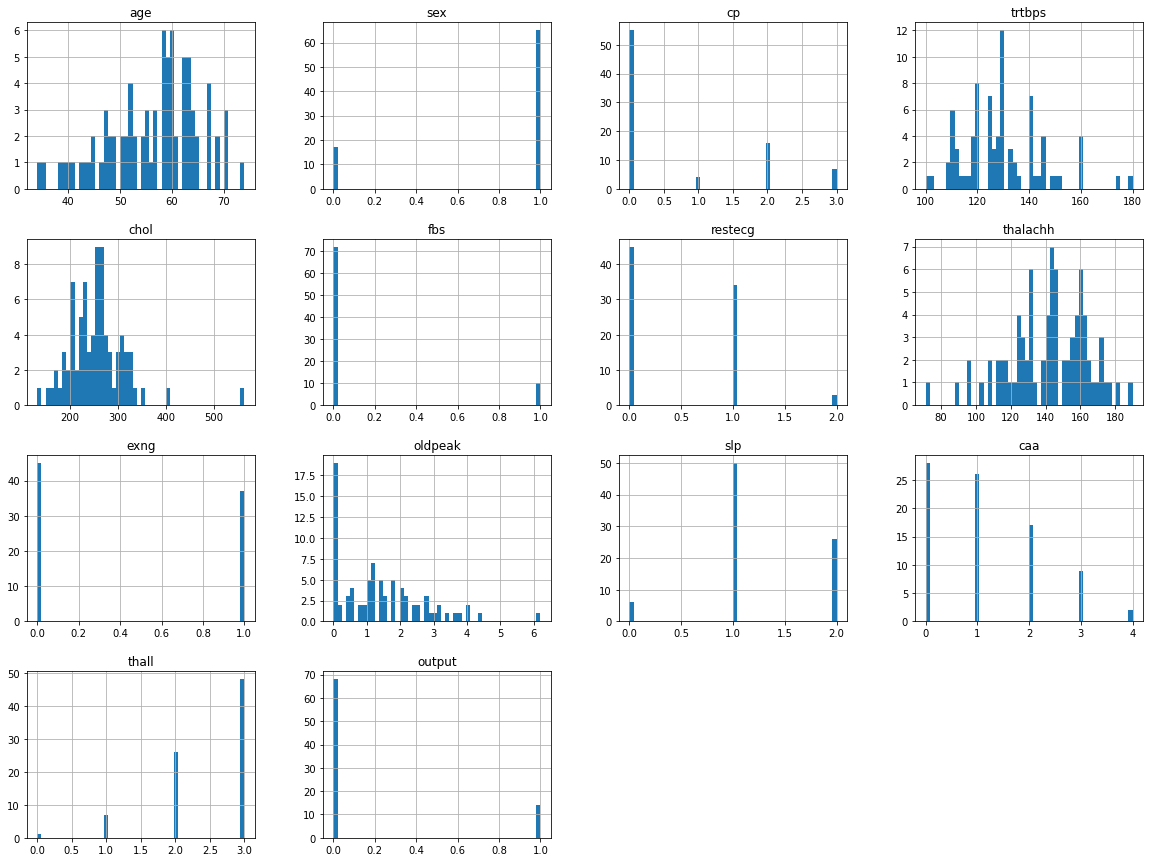

In [76]:
fig3_medium = df3_medium.hist(bins=50, figsize=(20,15))

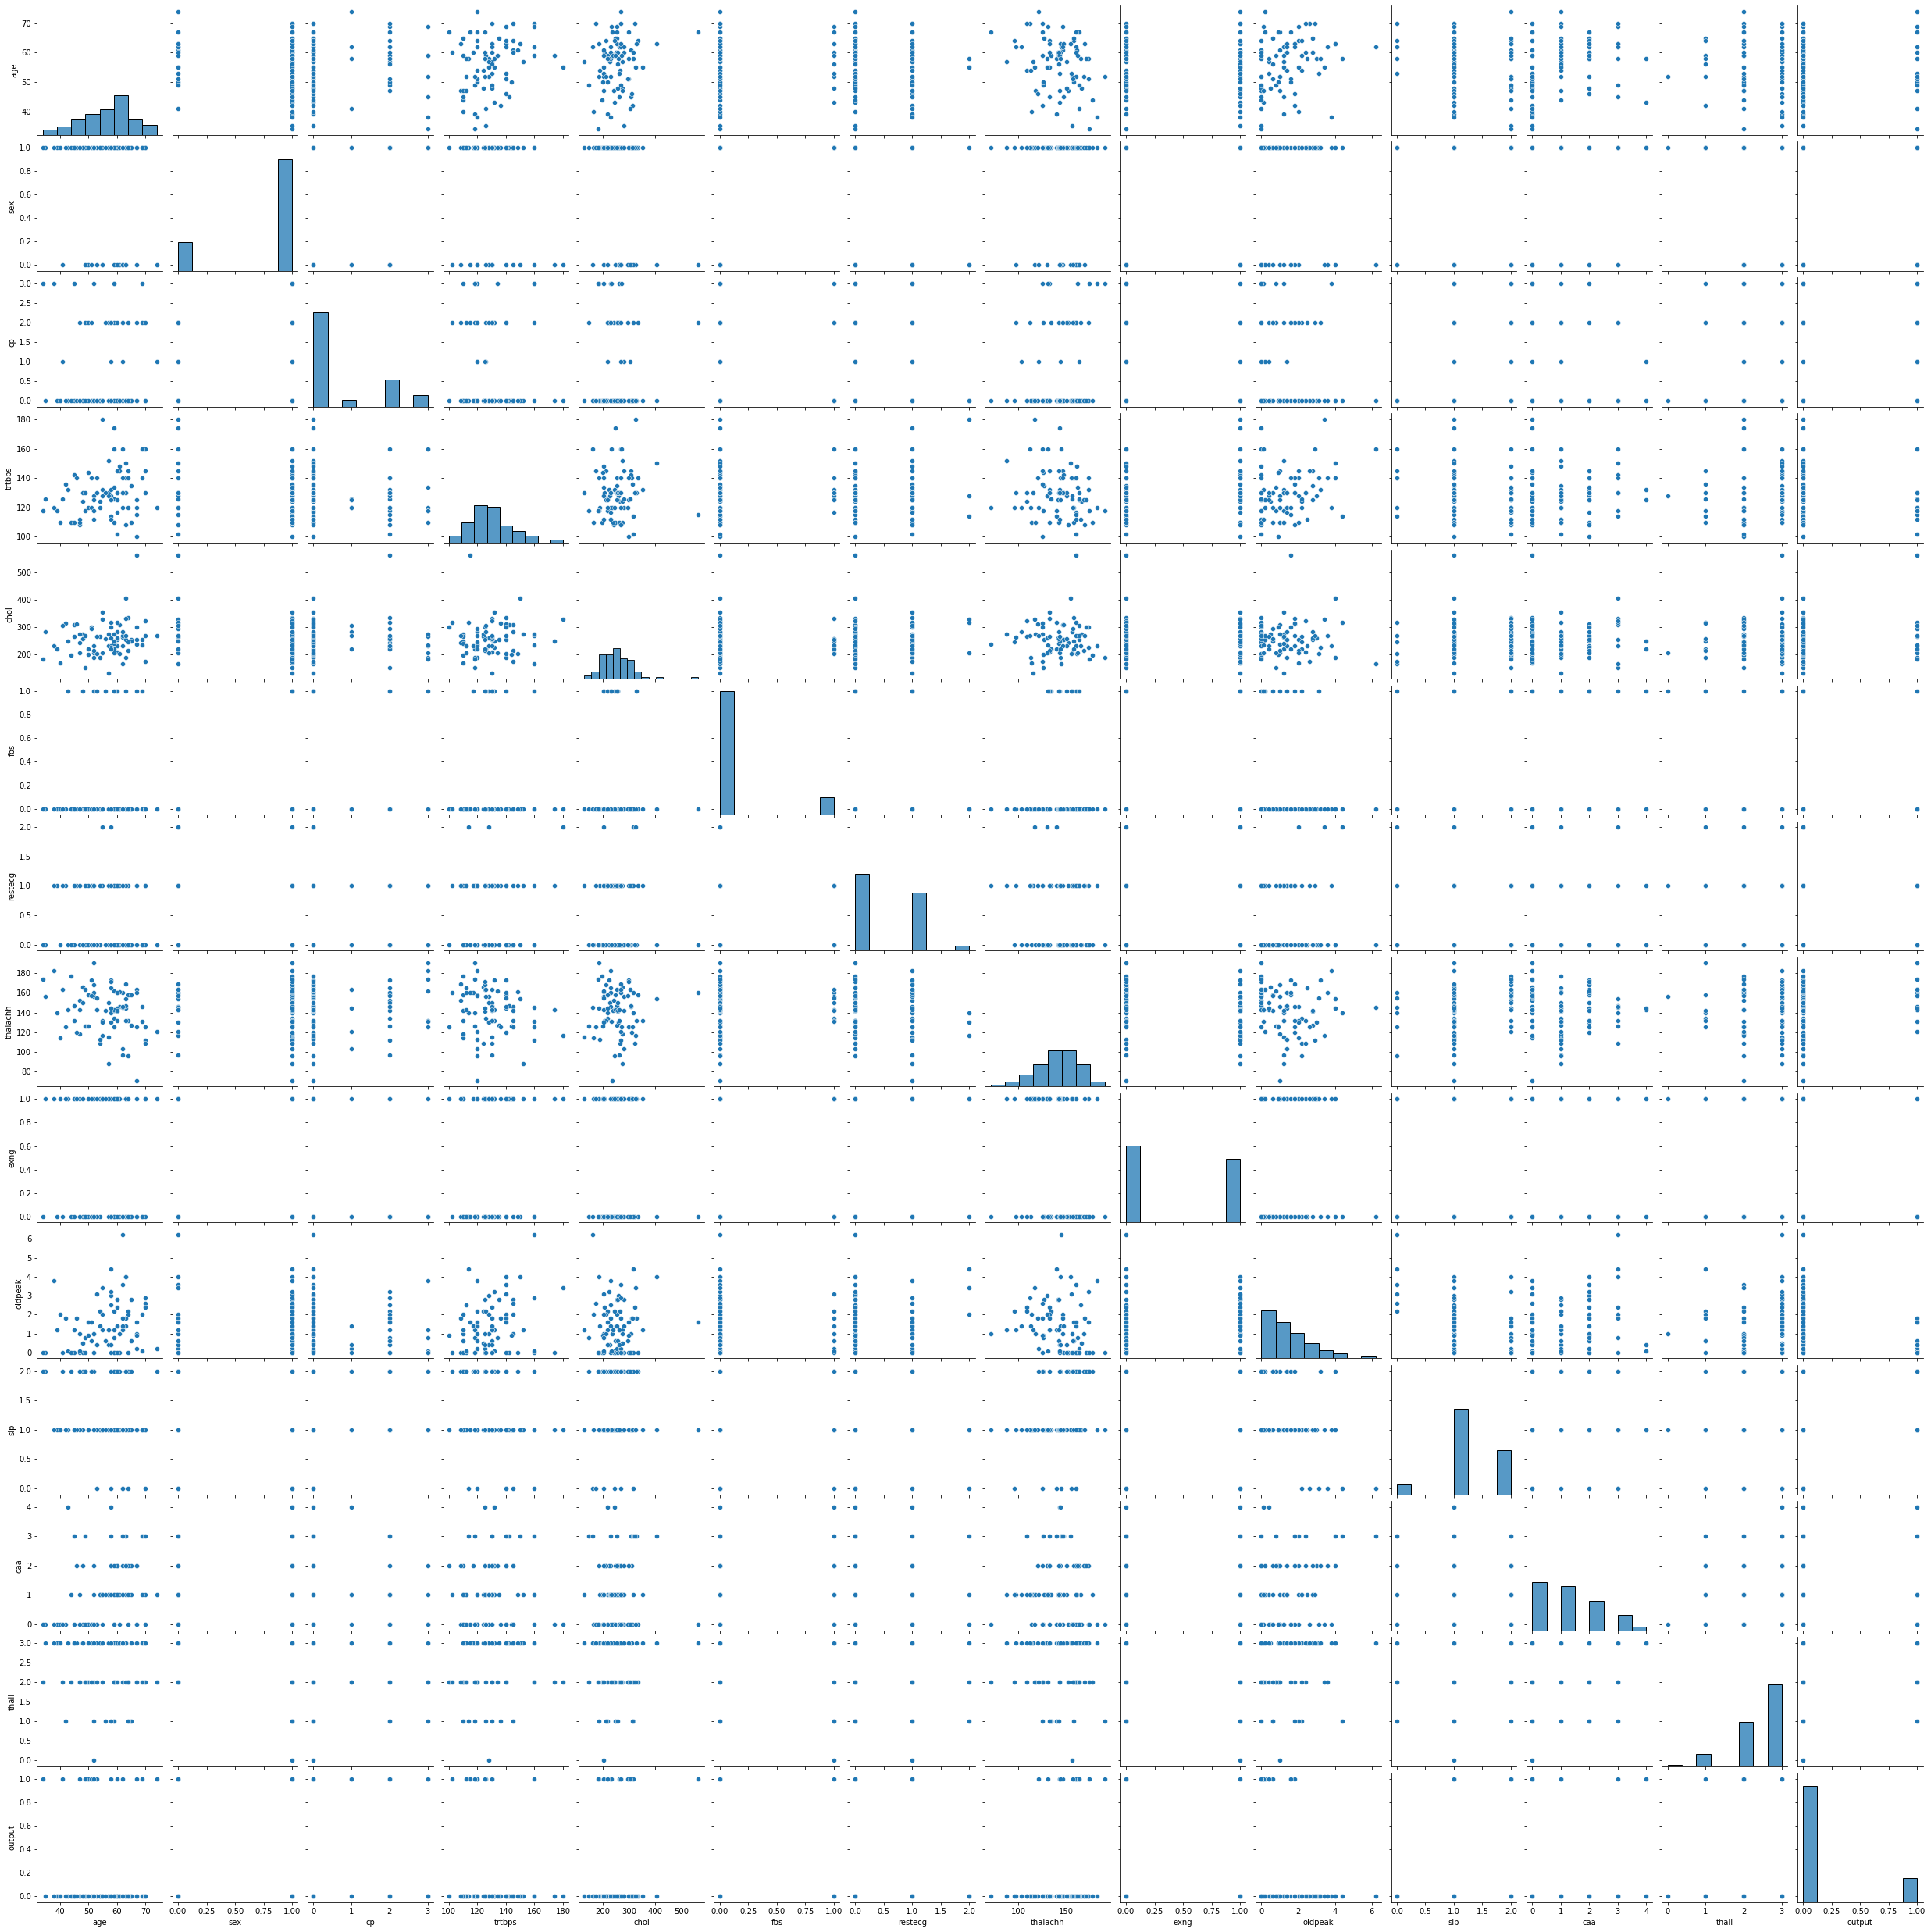

In [77]:
# Scatterplots
fig3_1_medium= sns.pairplot(df3_medium)

## High imbalance on heart attack data set

In [78]:
df3_high_1=df3.loc[df3['output'] == 0]
df3_high_2=df3.loc[df3['output']==1]

In [79]:
df3_high_1 = df3_high_1.sample(frac =.90)
df3_high_2=df3_high_2.sample(frac=.10)

In [80]:
df3_high=pd.concat([df3_high_1,df3_high_2 ])
df3_high['output'].value_counts()

0    124
1     16
Name: output, dtype: int64

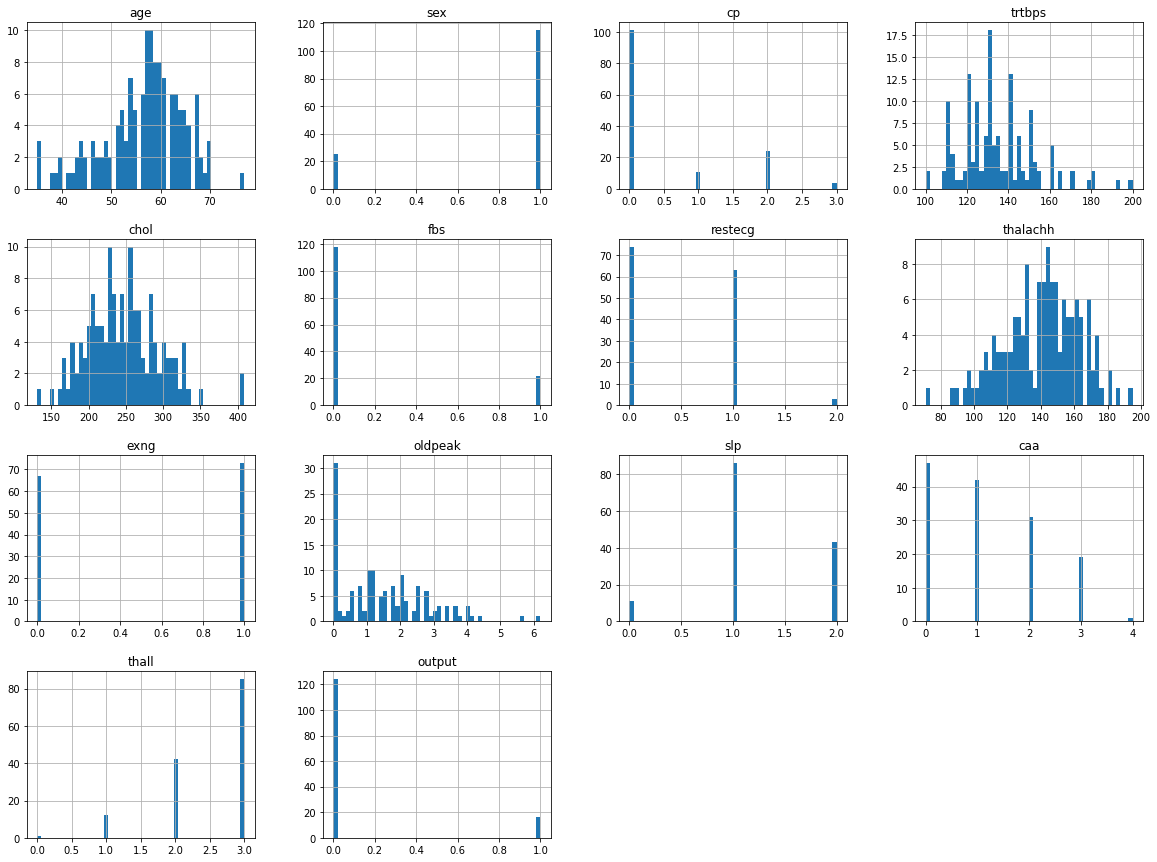

In [81]:
fig3_high = df3_high.hist(bins=50, figsize=(20,15))

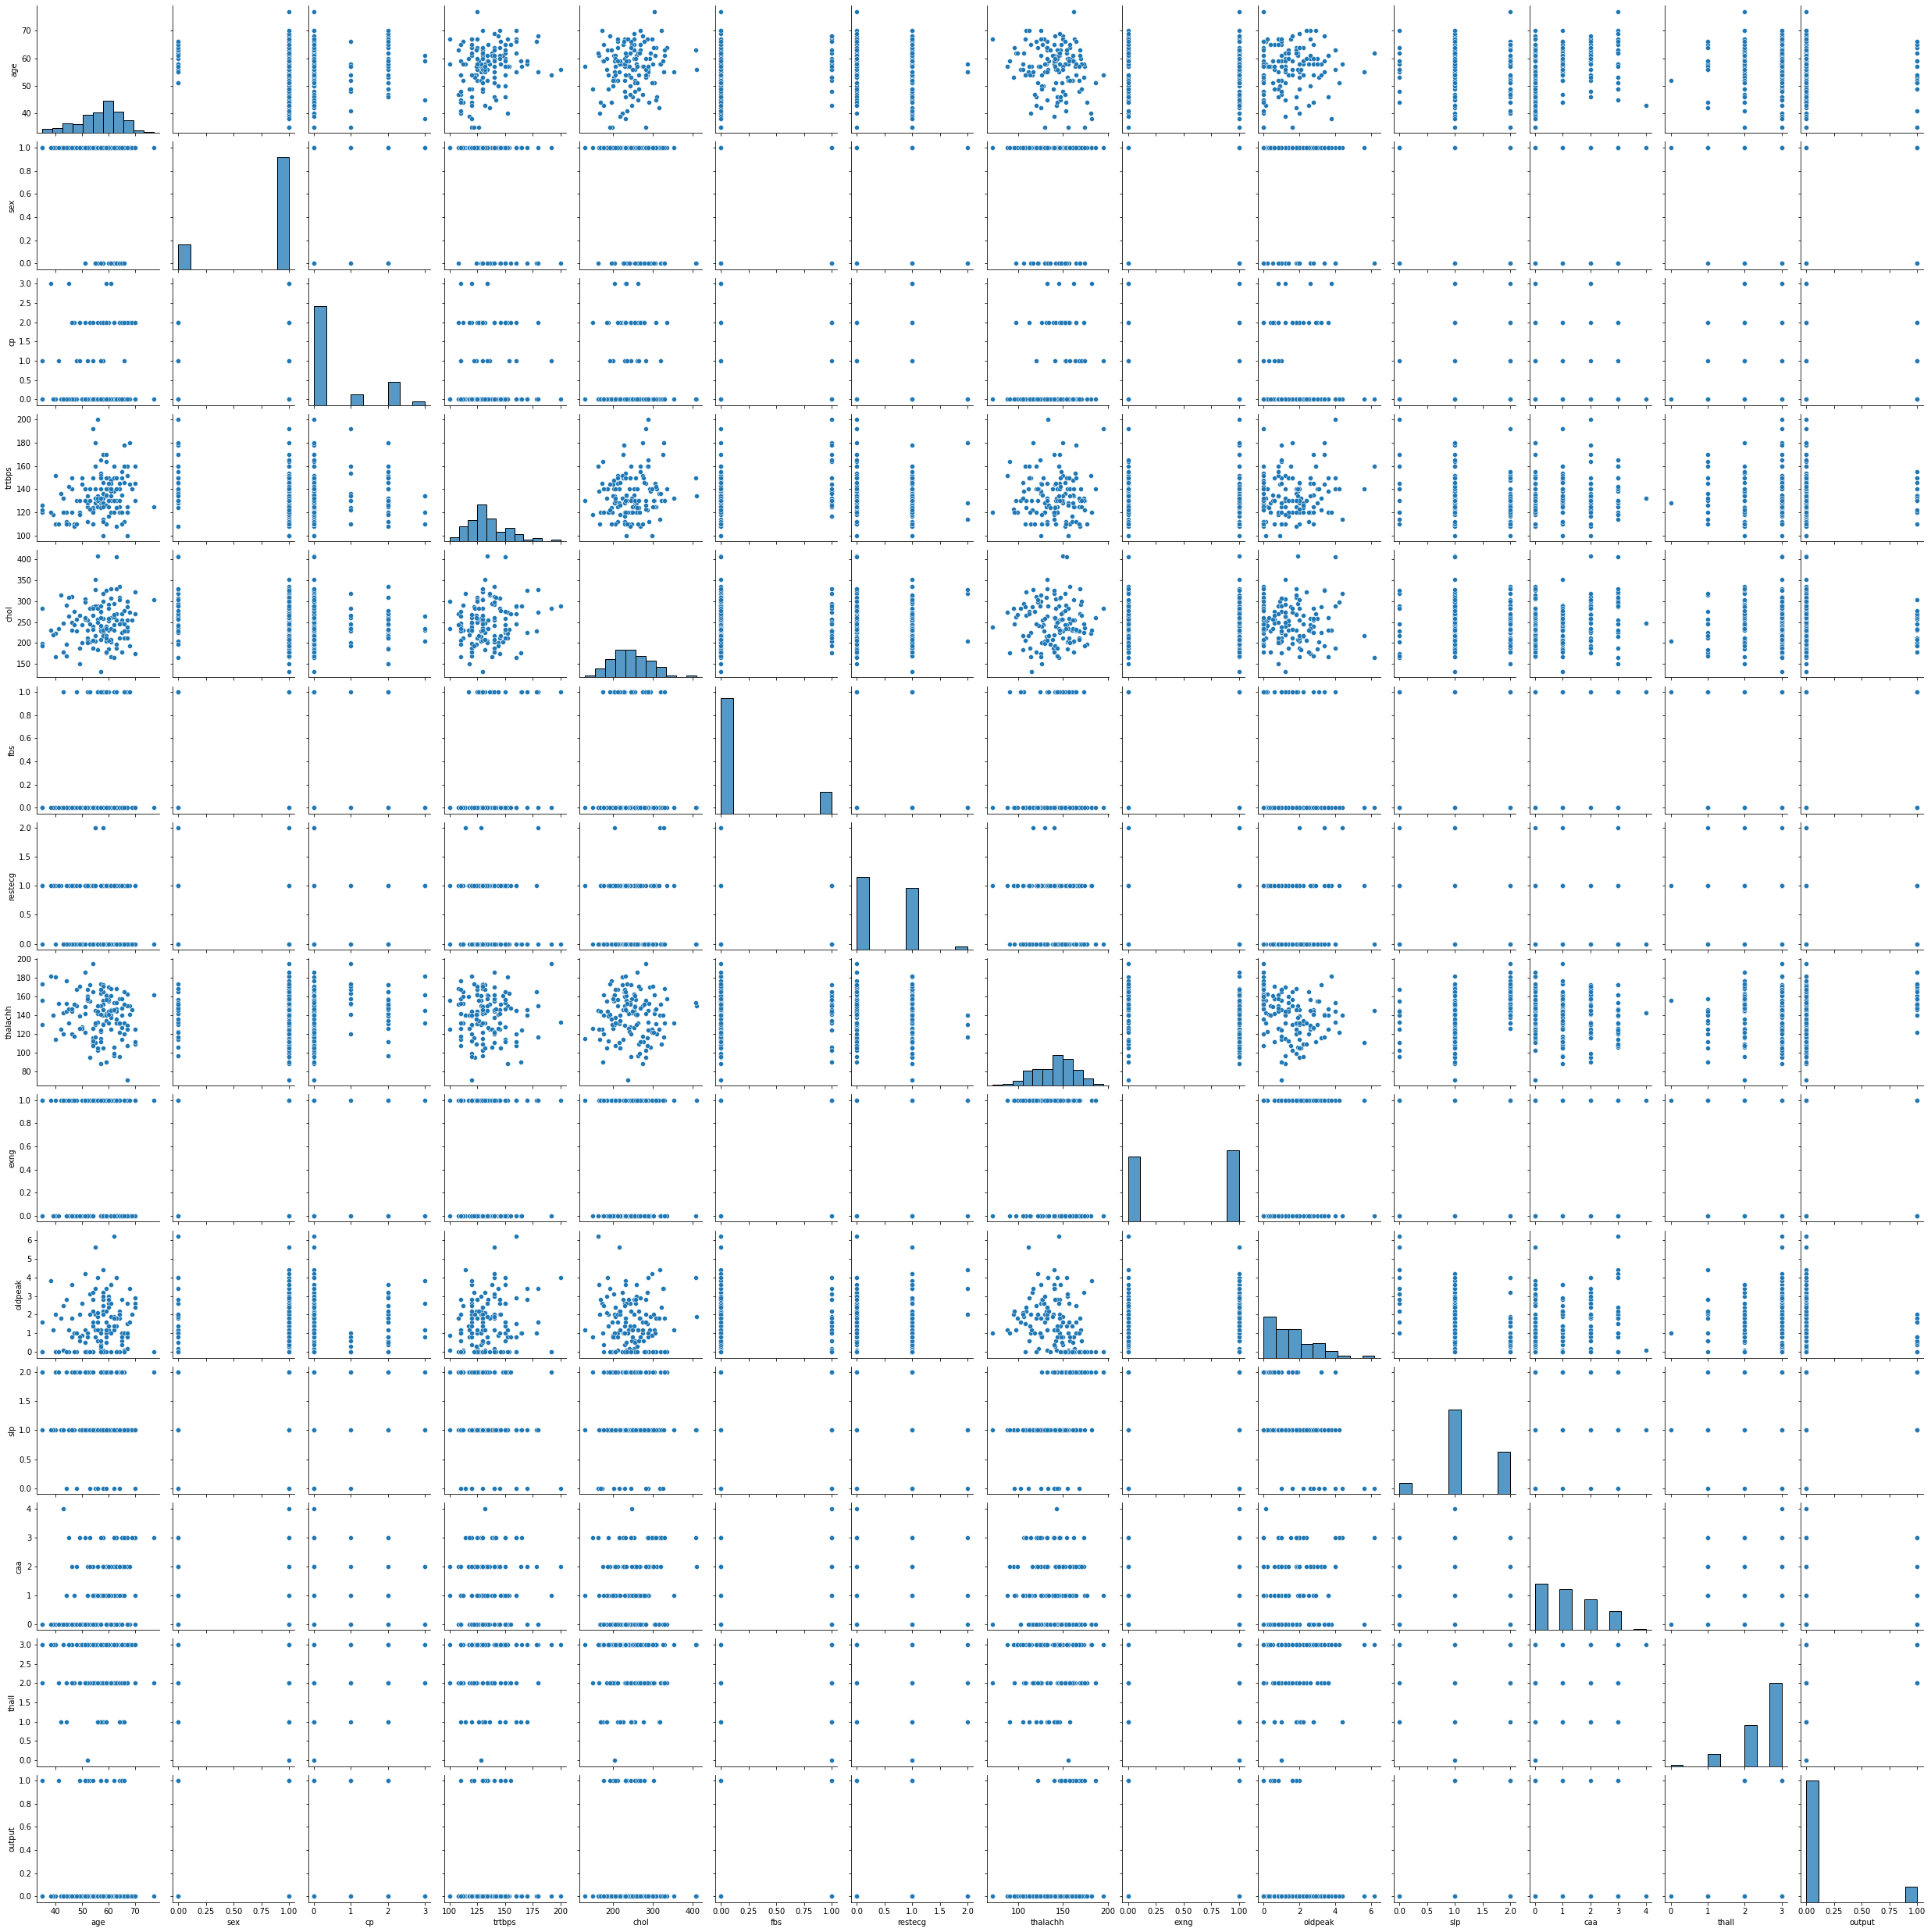

In [82]:
# Scatterplots
fig3_1_high= sns.pairplot(df3_high)